# Macro trends and sectoral equity performance

This notebook offers the necessary code to replicate the research findings discussed in the Macrosynergy research post “Macro trends and sectoral equity performance”. Its primary objective is to inspire readers to explore and conduct additional investigations whilst also providing a foundation for testing their own unique ideas.

Macroeconomic trends, such as economic growth, affect stocks differently, depending on their lines of business and their home markets. This means that point-in-time macro trend indicators can support two types of investment decisions: allocation across sectors within the same country and allocation across countries within the same sector. Panel analysis for 11 sectors and 12 countries over the last 25 years reveals examples for both. Across sectors, export growth, services business sentiment, and consumer confidence have predicted the outperformance of energy stocks, services stocks, and real estate stocks respectively. Across countries, relative export growth, manufacturing sentiment changes, and financial conditions have predicted the outperformance of local stocks versus foreign ones, for the overall market and within sectors.

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages used throughout the analysis.

- Transformations and checks: In this part, the notebook performs calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including building simple linear composite indicators.

- Value checks: This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. This section involves backtesting simple trading strategies. 

It is important to note that while the notebook covers a selection of indicators and strategies used for the post’s main findings, users can explore countless other possible indicators and approaches. Users can modify the code to test different hypotheses and strategies based on their research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [1]:
# Run only if needed!
# !pip install macrosynergy --upgrade

In [2]:
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib.pyplot as plt
import seaborn as sns

import copy
import warnings
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn
import macrosynergy.visuals as msv
from macrosynergy.download import JPMaQSDownload

warnings.simplefilter("ignore")

This notebook downloads selected indicators for the following cross-sections: AUD (Australian dollar), CAD (Canadian dollar), CHF (Swiss franc), EUR (euro), GBP (British pound),  HKD (Hong Kong dollar),  ILS (Israeli shekel), JPY (Japanese yen), NOK (Norwegian krone), NZD (New Zealand dollar), SEK (Swedish krona), SGD (Singapore dollar), USD (U.S. dollar) as well as five main European currencies  ['DEM', 'ESP', 'FRF', 'ITL', 'NLG'], replaced by EUR.

In [3]:
# Equity cross-section lists

# Cross-sections of interest
cids_dmeq = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'HKD', 'ILS', 'JPY', 'NOK', 'NZD', 'SEK', 'SGD', 'USD']
cids_eueq = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']

cids = sorted(cids_dmeq + cids_eueq)
cids_eqx = list(set(cids_dmeq) - {'HKD'})

In [4]:
sector_labels = {
    "ALL": "All sectors", 
    "COD": "Cons. discretionary",
    "COS": "Cons. staples",
    "CSR": "Communication services",
    "ENR": "Energy",
    "FIN": "Financials",
    "HLC": "Healthcare",
    "IND": "Industrials",
    "ITE": "Information tech",
    "MAT": "Materials",
    "REL": "Real estate",
    "UTL": "Utilities",
}
secx = list(sector_labels.keys())
secs = list(sector_labels.keys())[1:]

JPMaQS indicators are conveniently grouped into 6 main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available either under [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected) or the [Macro Quantamental Academy](https://academy.macrosynergy.com/quantamental-indicators/). In particular, the indicators used in this notebook can be found under [Manufacturing confidence scores](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Manufacturing%20confidence%20scores.php), [Industrial production trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Industrial%20production%20trends.php), [Foreign trade trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Foreign%20trade%20trends.php), [Services confidence scores](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Services%20confidence%20scores.php), [Private consumption](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Private%20consumption.php), [Global production shares](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/Shares%20in%20global%20production.php?highlight=usdgdpwgt), [Private credit expansion](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Private%20credit%20expansion.php), [Consumer price inflation trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Consumer%20price%20inflation%20trends.php), [U.S. special data](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/U.S.%20special%20data.php), [GDP growth](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/GDP%20growth.php), [Intuitive GDP growth estimates](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Intuitive%20GDP%20growth%20estimates.php), [Inflation targets](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20targets.php), and [Real interest rates](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Real%20interest%20rates.php), 

In [5]:
# Category tickers

# Economic indicators

manuf = [
    # Manufacturing confidence scores
    "MBCSCORE_SA",
    "MBCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA_D1Q1QL1",
    # Short term industrial production trend
    "IP_SA_P3M3ML3AR",
    "IP_SA_P6M6ML6AR",
    "IP_SA_P1M1ML12_3MMA",
    # Export growth
    "EXPORTS_SA_P6M6ML6AR",
    "EXPORTS_SA_P1M1ML12_3MMA"
]
servi = [
    # Service confidence scores
    "SBCSCORE_SA",
    "SBCSCORE_SA_D3M3ML3",
    "SBCSCORE_SA_D1Q1QL1",
]
consu = [
    # Consumer confidence scores
    "CCSCORE_SA",
    "CCSCORE_SA_D3M3ML3",
    "CCSCORE_SA_D1Q1QL1",
    # private credit
    "PCREDITBN_SJA_P1M1ML12", 
]
cpi = [
    # Consumer core inflation: YoY, QoQ annualised
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
]
ppi = [
    # Producer Inflation: YoY, QoQ annualised
    "PPIH_NSA_P1M1ML12",
    "PPIH_SA_P3M3ML3AR",
]

ecos = manuf + servi + consu + cpi + ppi

# Complementary economic indicators
ecox = [
    "IVAWGT_SA_1YMA",
    "USDGDPWGT_SA_1YMA",
    "RGDP_SA_P1Q1QL4_20QMM",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INFTEFF_NSA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
]

# Market indicators
eqrets = ["EQC" + sec + ret for sec in secx for ret in ["R_NSA", "XR_NSA"]]
eqblack = ["EQC" + sec + "UNTRADABLE_NSA" for sec in secx]
fxrets = ["FXXRUSD_NSA"]
marks = eqrets + eqblack + fxrets

# All indicators
xcats = ecos + ecox + marks

# Resultant tickers
tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 1134


The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md).


In [6]:
client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(oauth=True, client_id=client_id, client_secret=client_secret) as dq:
    assert dq.check_connection()
    df = dq.download(
        tickers=tickers,
        start_date="1990-01-01",
        suppress_warning=True,
        metrics=["value"],
        show_progress=True,
    )
    assert isinstance(df, pd.DataFrame) and not df.empty

#print("Last updated:", date.today())

Timestamp UTC:  2025-03-05 15:53:05
Connection successful!


Requesting data: 100%|██████████| 57/57 [00:11<00:00,  4.97it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
125 out of 1134 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 9180 dates are missing.


In [7]:
dfx = df.copy().sort_values(["cid", "xcat", "real_date"])
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8375198 entries, 36273 to 8368261
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   value      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 319.5+ MB


### Renaming and availability

Rename quarterly tickers to roughly equivalent monthly tickers to simplify subsequent operations.

In [8]:
dict_repl = {
    # surveys
    "CCSCORE_SA_D1Q1QL1": "CCSCORE_SA_D3M3ML3",
    "SBCSCORE_SA_D1Q1QL1": "SBCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA_D1Q1QL1": "MBCSCORE_SA_D3M3ML3",
}

for key, value in dict_repl.items():
    dfx["xcat"] = dfx["xcat"].str.replace(key, value)

It is important to assess data availability before conducting any analysis. It allows identifying any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available as well as determining the appropriate time periods for analysis. 

In [9]:
ecos_xq = list(set(ecos) - set(dict_repl.keys()))
msm.missing_in_df(df, xcats=ecos_xq, cids=cids)

No missing XCATs across DataFrame.
Missing cids for CCSCORE_SA:                ['HKD', 'SGD']
Missing cids for CCSCORE_SA_D3M3ML3:        ['CHF', 'HKD', 'NZD', 'SGD']
Missing cids for CPIC_SA_P1M1ML12:          ['HKD']
Missing cids for CPIC_SJA_P3M3ML3AR:        ['HKD']
Missing cids for EXPORTS_SA_P1M1ML12_3MMA:  ['DEM', 'ESP', 'FRF', 'HKD', 'ITL', 'NLG']
Missing cids for EXPORTS_SA_P6M6ML6AR:      ['DEM', 'ESP', 'FRF', 'HKD', 'ITL', 'NLG']
Missing cids for IP_SA_P1M1ML12_3MMA:       ['HKD']
Missing cids for IP_SA_P3M3ML3AR:           ['HKD']
Missing cids for IP_SA_P6M6ML6AR:           ['HKD']
Missing cids for MBCSCORE_SA:               []
Missing cids for MBCSCORE_SA_D3M3ML3:       ['HKD']
Missing cids for PCREDITBN_SJA_P1M1ML12:    ['DEM', 'ESP', 'FRF', 'HKD', 'ITL', 'NLG']
Missing cids for PPIH_NSA_P1M1ML12:         ['HKD']
Missing cids for PPIH_SA_P3M3ML3AR:         ['HKD']
Missing cids for SBCSCORE_SA:               ['HKD', 'NOK']
Missing cids for SBCSCORE_SA_D3M3ML3:       ['AUD'

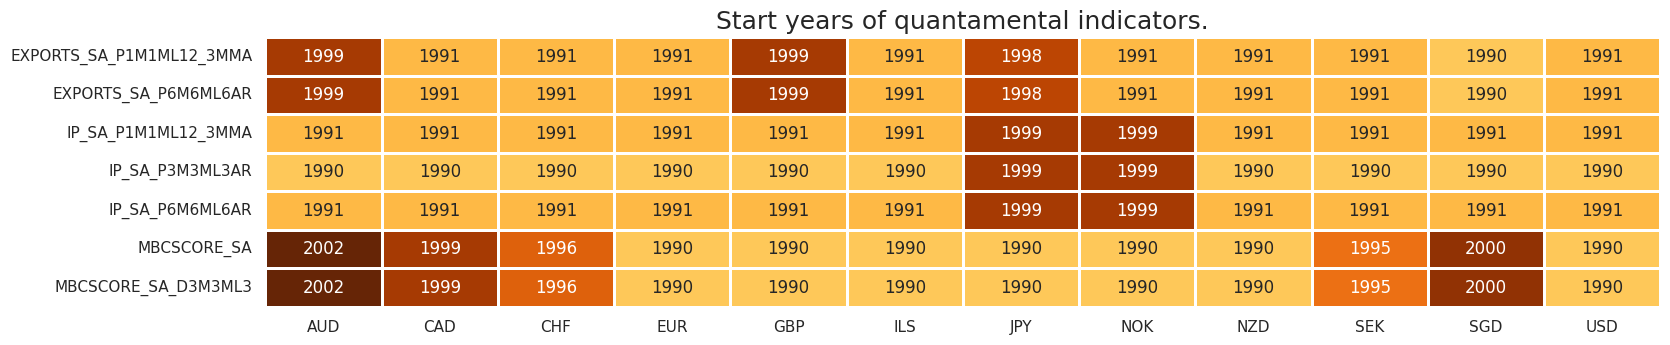

In [10]:
msm.check_availability(dfx, xcats=manuf, cids=cids_eqx, missing_recent=False)

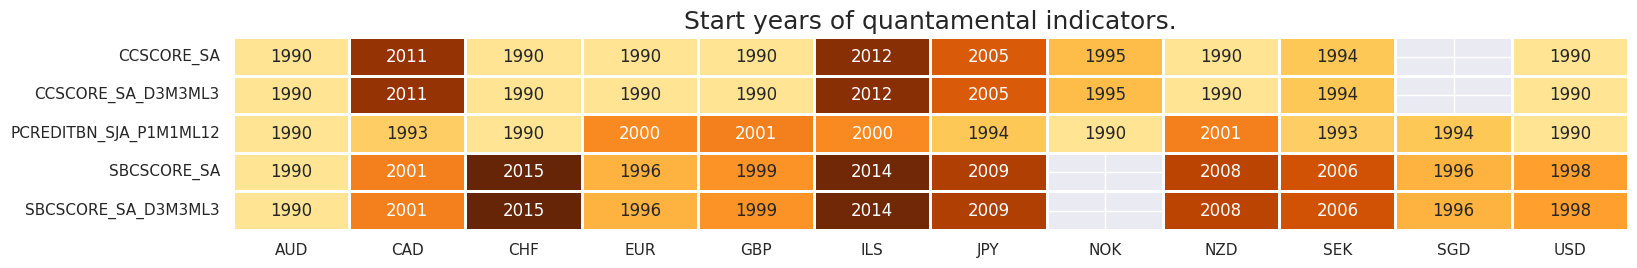

In [11]:
msm.check_availability(dfx, xcats=servi+consu, cids=cids_eqx, missing_recent=False)

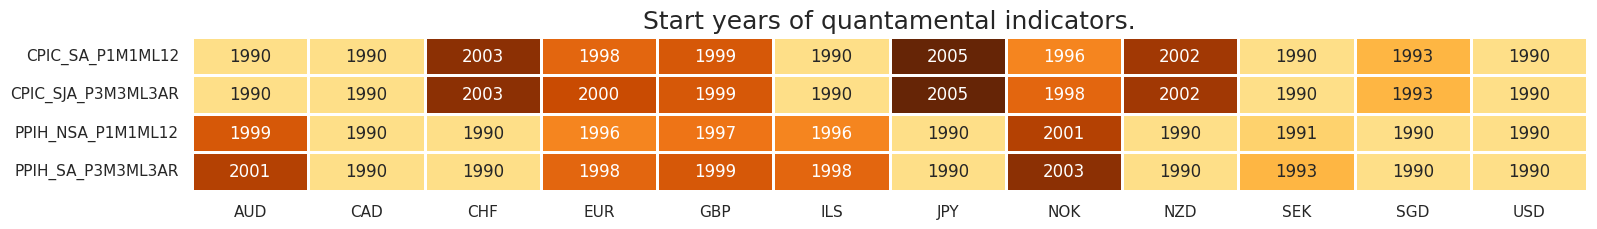

In [12]:
msm.check_availability(dfx, xcats=cpi+ppi, cids=cids_eqx, missing_recent=False)

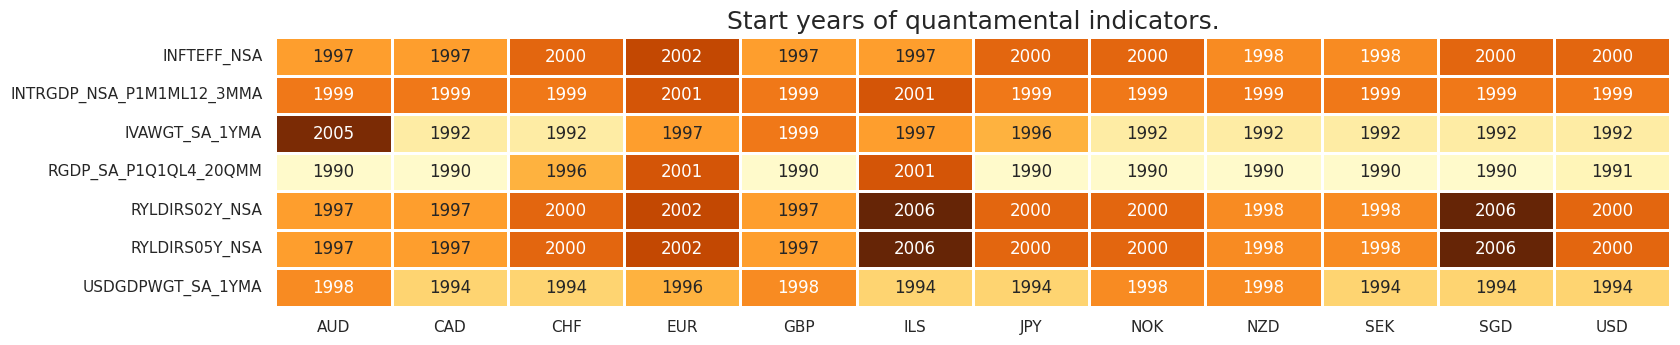

In [13]:
msm.check_availability(dfx, xcats=ecox, cids=cids_eqx, missing_recent=False)

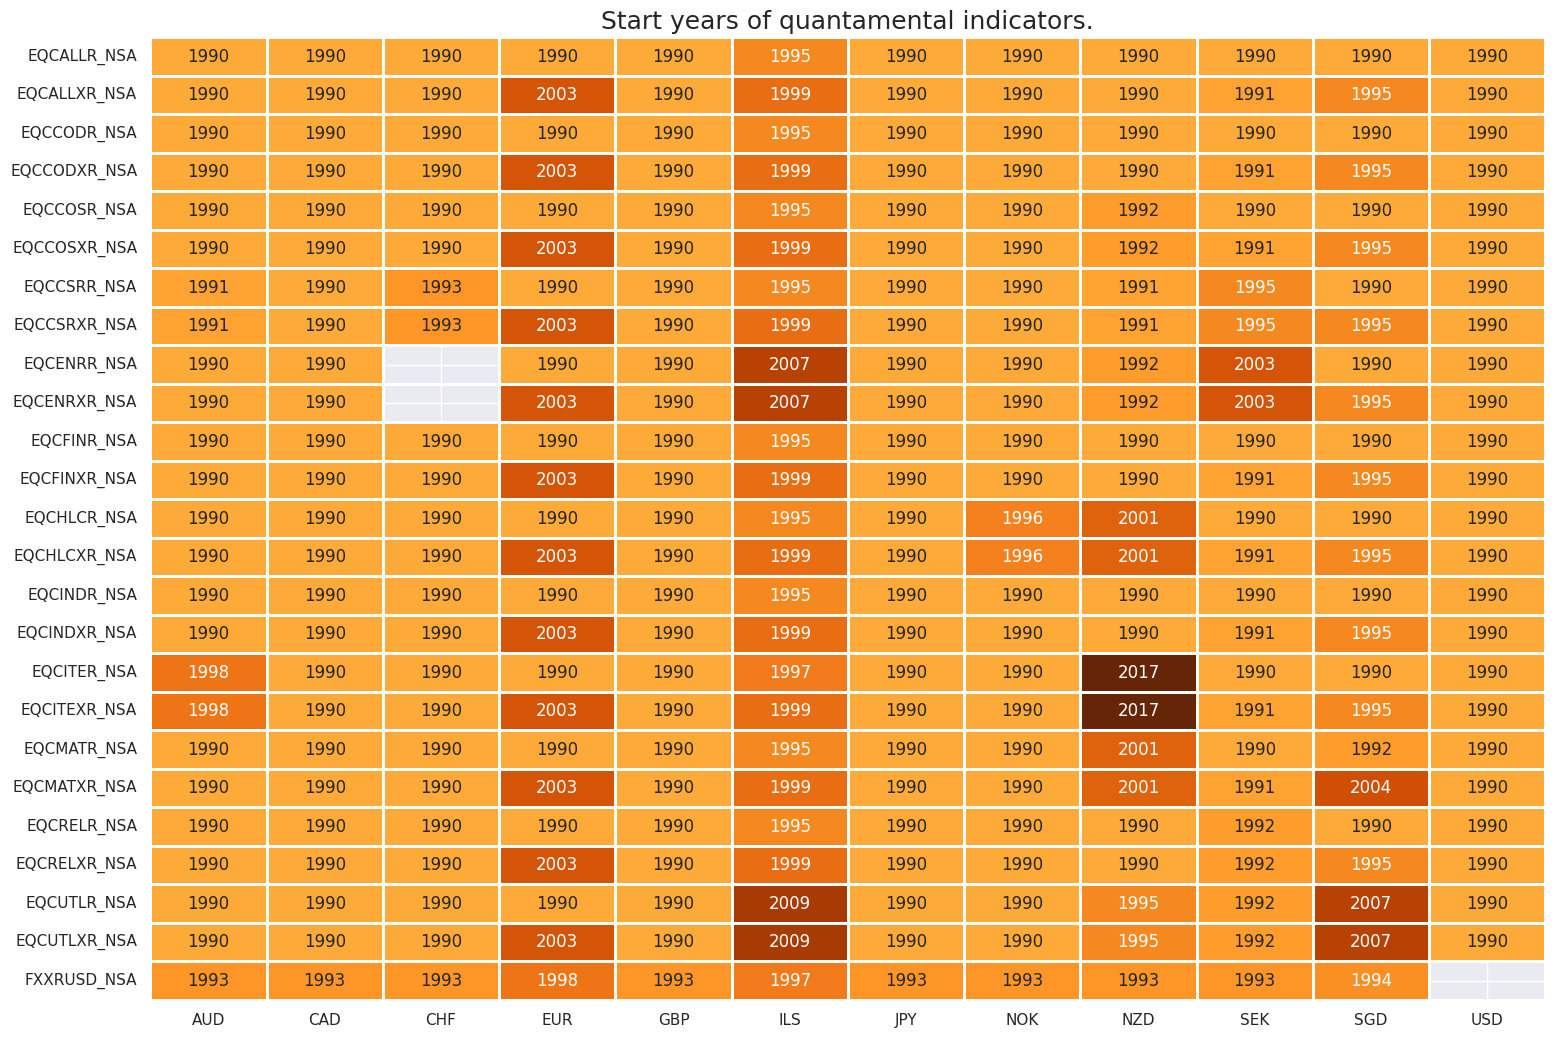

In [14]:
msm.check_availability(dfx, xcats=eqrets+fxrets, cids=cids_eqx, missing_recent=False)

## Transformations and checks

### Features 

The [`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the `macrosynergy` package, is employed to aggregate the individual category scores into a unified composite indicator. This method offers the flexibility to assign specific weights to each category, which can vary over time.

For global industry indicators we use the respective [`IVAWGT_SA_1YMA`](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/Shares%20in%20global%20production.php?highlight=usdgdpwgt), the share in industrial production or world GDP (USD terms), as concurrent weight.

In [15]:
# Global industry indicators
iris = list(set(manuf + ppi).intersection(ecos_xq))  # industry-related indicators
xcatx = iris
cidx = cids_eqx
sdate = "1990-01-01"

dfa = pd.DataFrame(columns=dfx.columns)
for xcat in xcatx:
    dfaa = msp.linear_composite(
        df=dfx,
        xcats=xcat,
        cids=cidx,
        complete_xcats=False,
        start=sdate,
        weights='IVAWGT_SA_1YMA'
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

For services and consumption indicator composite we employ as weight [`'USDGDPWGT_SA_1YMA'`](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/Shares%20in%20global%20production.php?highlight=usdgdpwgt) denoting the share in world GDP (USD terms): based on 1-year moving average. 

In [16]:
# Global services and consumption indicators

cscs = list(set(servi + consu + cpi).intersection(ecos_xq))
xcatx = cscs
cidx = cids_eqx
sdate = "1990-01-01"

dfa = pd.DataFrame(columns=dfx.columns)
for xcat in xcatx:
    dfaa = msp.linear_composite(
        df=dfx,
        xcats=xcat,
        cids=cidx,
        complete_xcats=False,
        start=sdate,
        weights='USDGDPWGT_SA_1YMA'
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

[`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package is used to plot the timelines of the created global indicators:

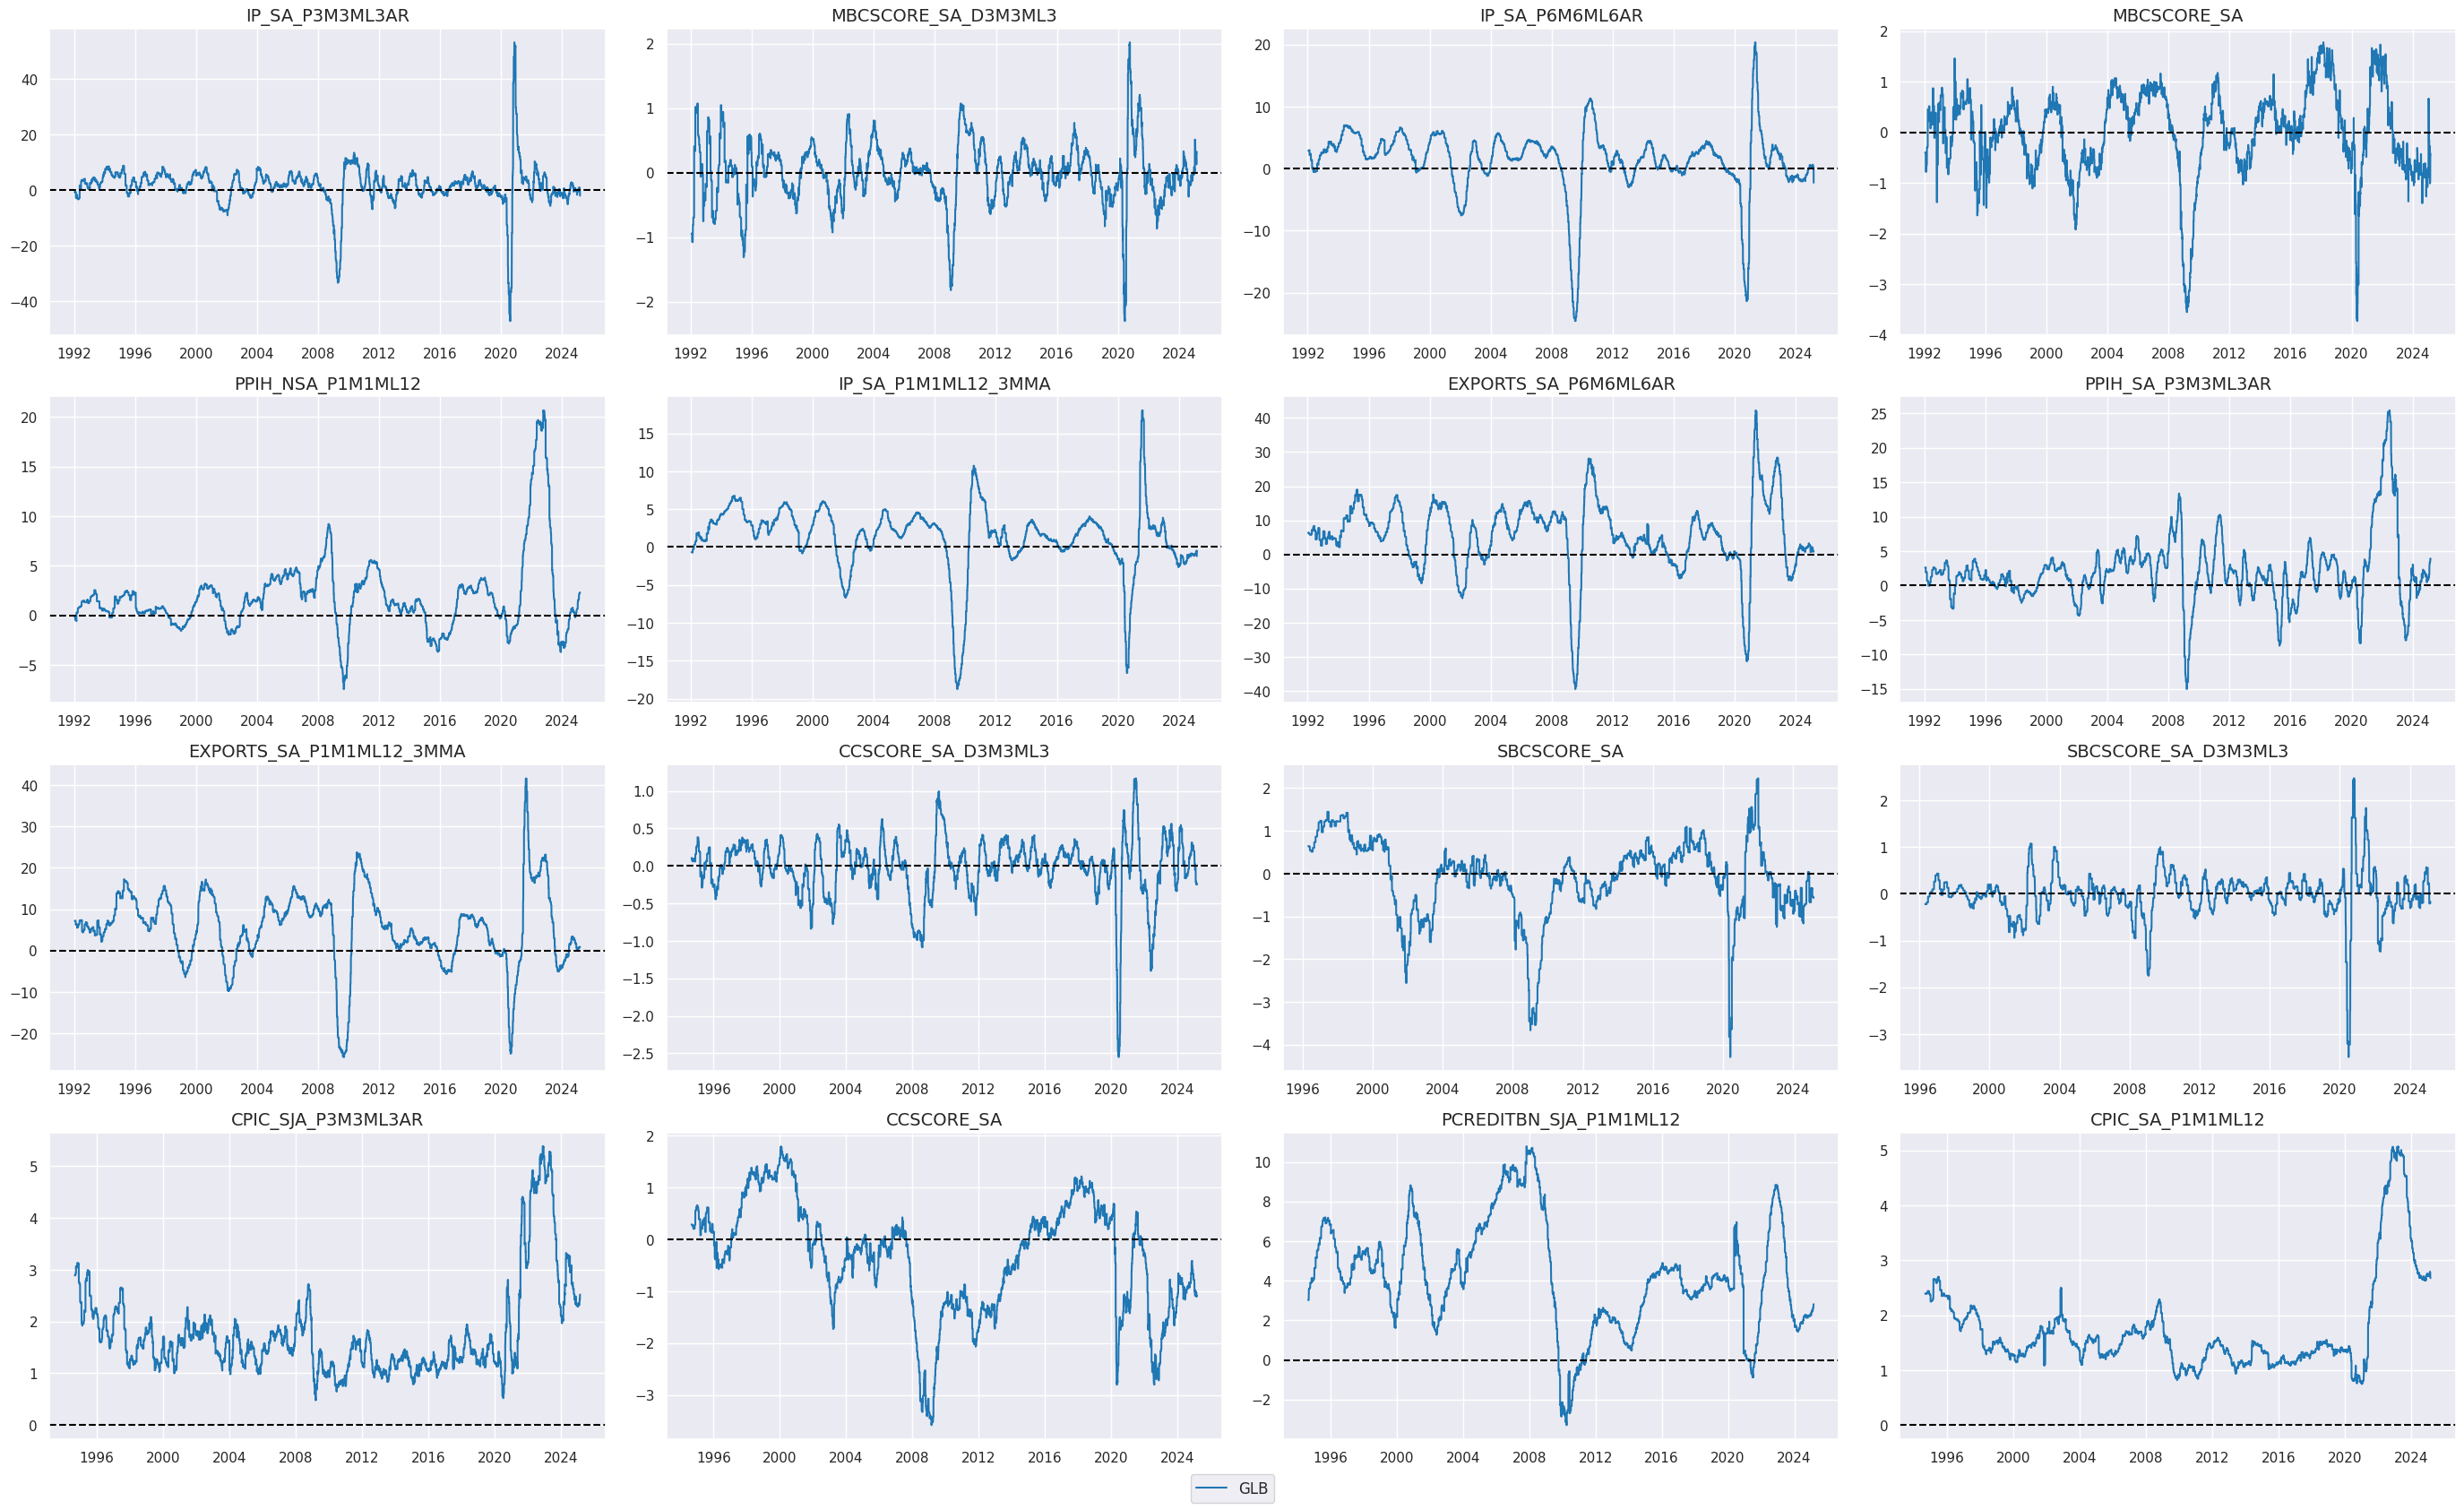

In [17]:
xcatx = iris + cscs
cidx = 'GLB'
start_date = "1990-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start=start_date,
    title=None,
    cumsum=False,
    ncol=4,
    same_y=False,
    size=(12, 7),
    all_xticks=True,
    xcat_grid=True,
)

### Targets

In addition to the standard sectoral equity returns, we build new return series to be able to analyse the country's sectoral performance in excess of the local equity market and in excess of the global sector performance.

### Cross-sector returns (for all countries)

We compute the sector-specific return `vALL` in a given region by subtracting from each indicator the equal-weighted average of sector returns of the corresponding cross-section. To do this, we apply the Macrosynergy package method `make_relative_category()` from the `macrosynergy` package.

An alternative option would be subtracting the aggregate equity index return `EQCALLR_NSA` from each of the sectoral returns.

In [18]:
cidx = cids_eqx
dfa = pd.DataFrame(columns=dfx.columns)

for ret in ["R", "XR"]:
    xcatx = [f"EQC{sec}{ret}_NSA" for sec in secs]
    dfaa = msp.make_relative_category(
        df=dfx,
        xcats=xcatx,
        cids=cidx,
        start="1990-01-01",
        basket=None,
        complete_set=False,
        rel_meth="subtract",
        postfix="vALL",
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

The cross section, CHF, is missing ['EQCENRR_NSA'] from the requested basket. The new basket will be ['EQCCODR_NSA', 'EQCCOSR_NSA', 'EQCCSRR_NSA', 'EQCFINR_NSA', 'EQCHLCR_NSA', 'EQCINDR_NSA', 'EQCITER_NSA', 'EQCMATR_NSA', 'EQCRELR_NSA', 'EQCUTLR_NSA'].
The cross section, CHF, is missing ['EQCENRXR_NSA'] from the requested basket. The new basket will be ['EQCCODXR_NSA', 'EQCCOSXR_NSA', 'EQCCSRXR_NSA', 'EQCFINXR_NSA', 'EQCHLCXR_NSA', 'EQCINDXR_NSA', 'EQCITEXR_NSA', 'EQCMATXR_NSA', 'EQCRELXR_NSA', 'EQCUTLXR_NSA'].


Since local returns are calculated based on the same funding costs across sectors, relative cash and excess returns are equal, except for different starting points of history. [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package is used to plot the timelines of the selected sector return (below - Information tech):

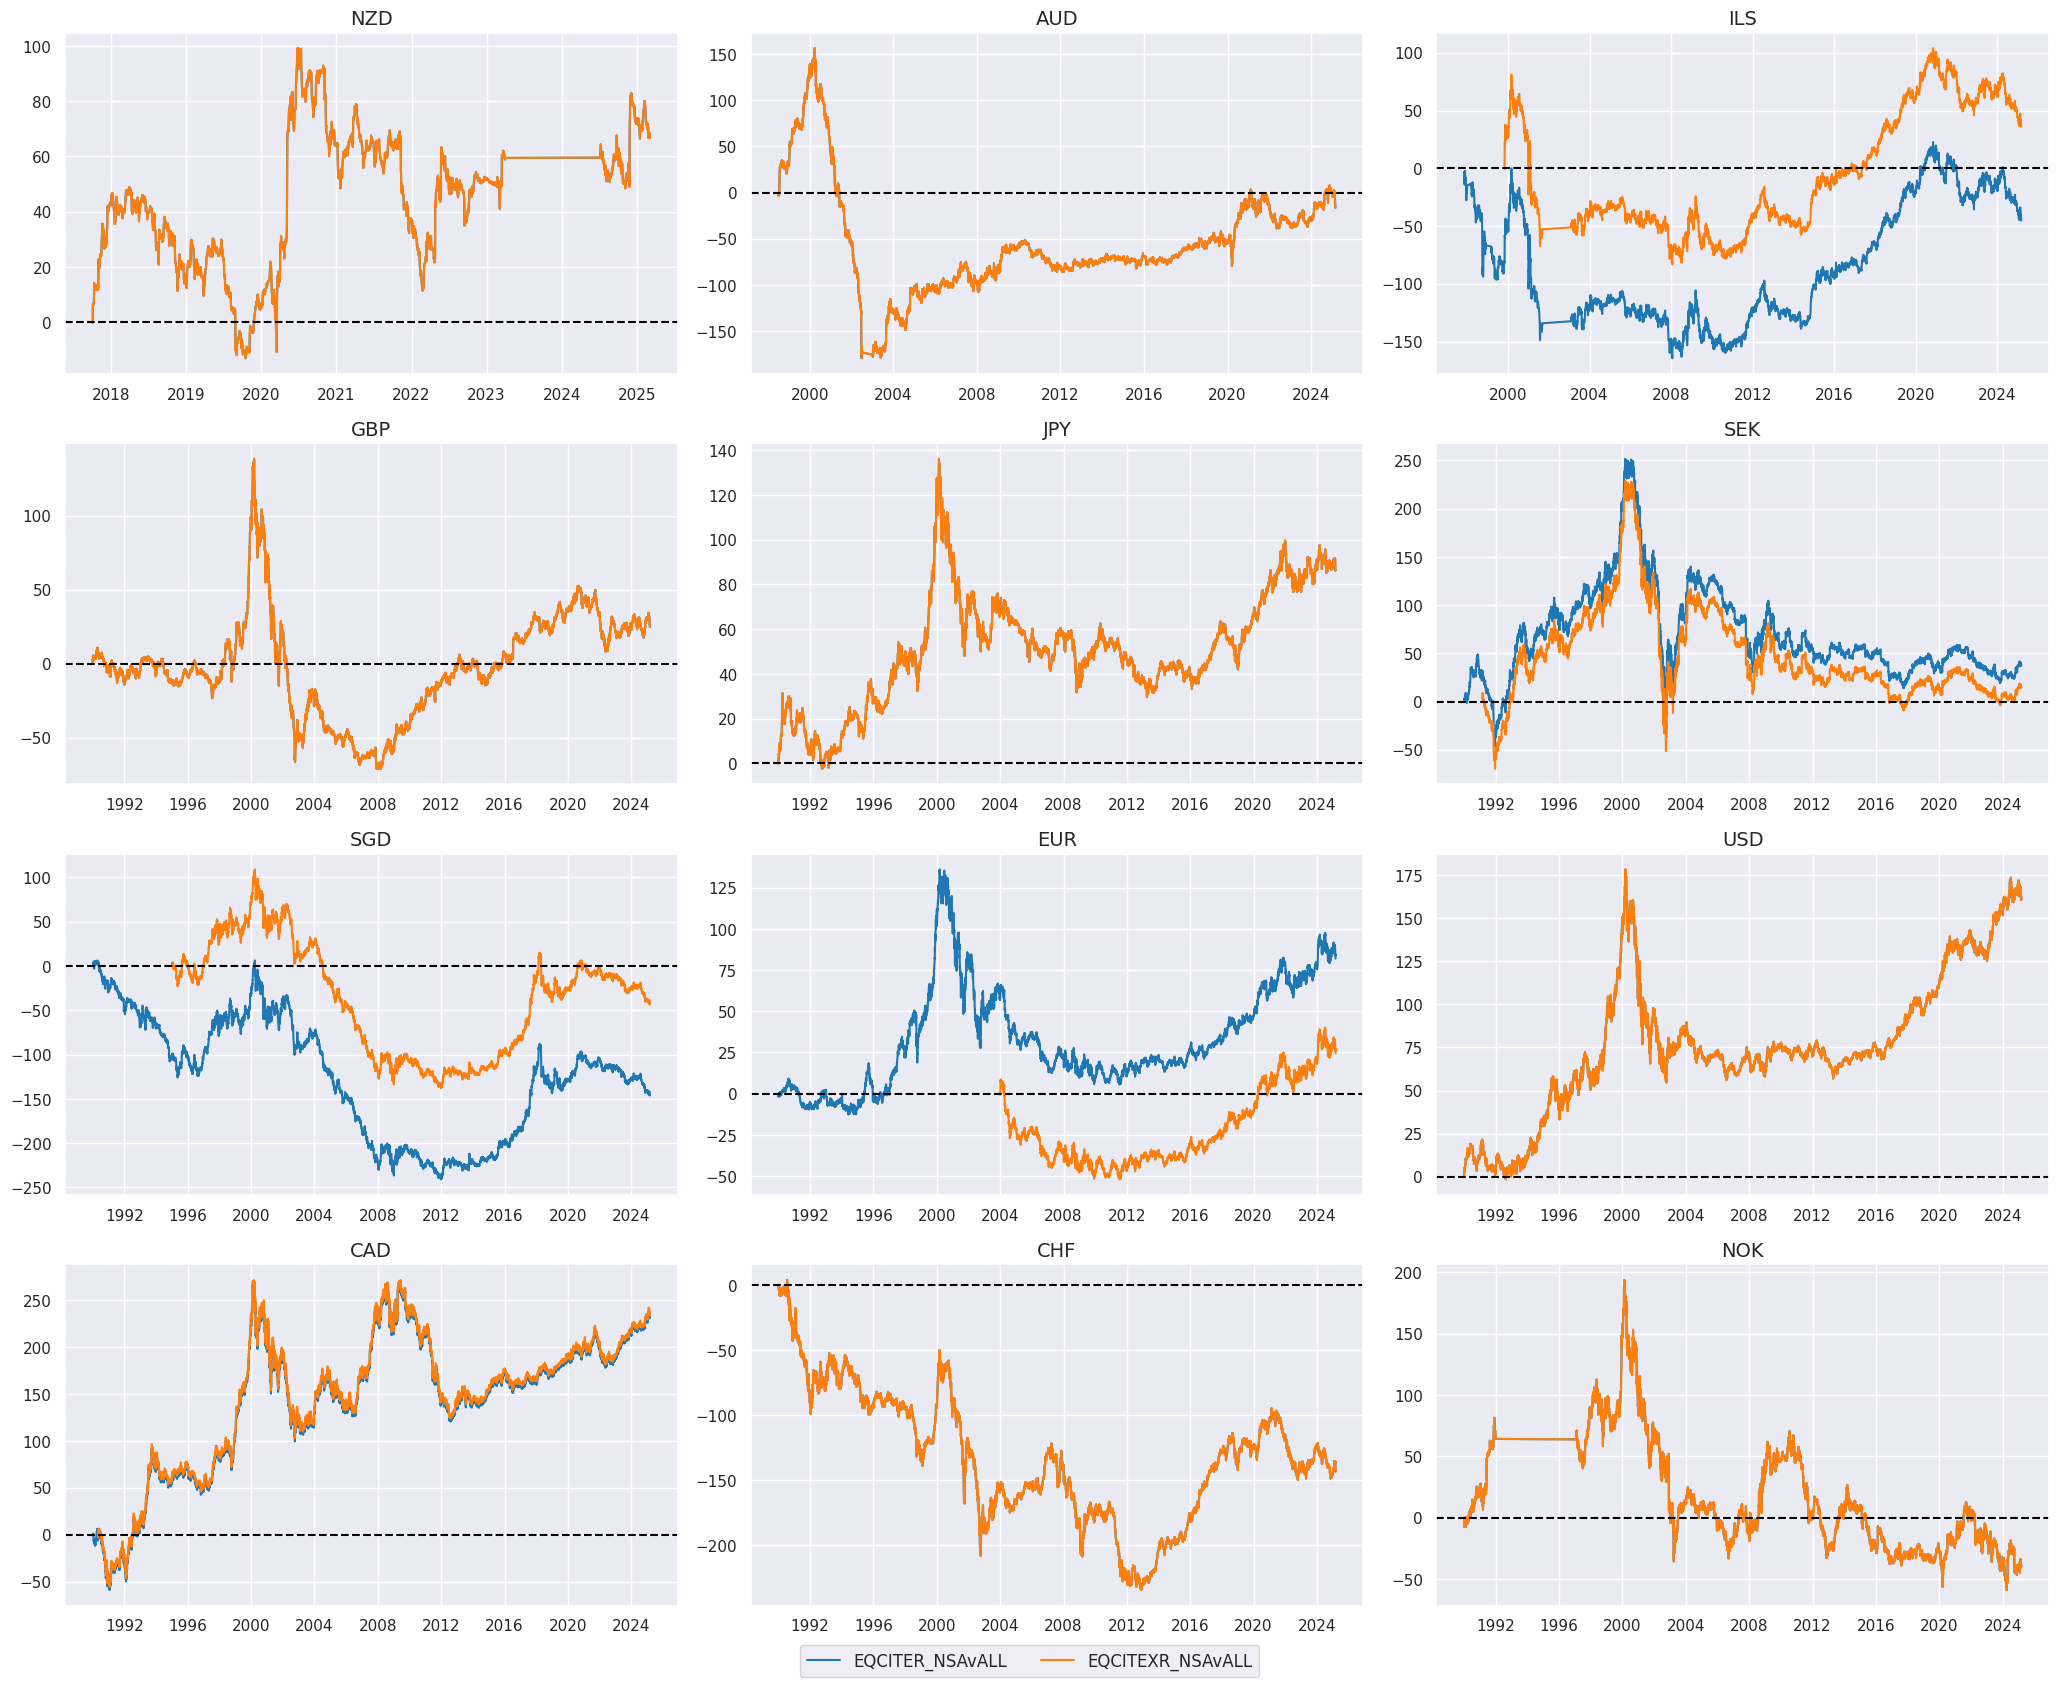

In [19]:
sec = "ITE"
xcatx = [
    f"EQC{sec}R_NSAvALL", 
    f"EQC{sec}XR_NSAvALL"
]
cidx = cids_eqx
start_date = "1990-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start=start_date,
    cumsum=True,
    ncol=3,
    same_y=False,
    size=(12, 7),
    all_xticks=True,
    xcat_grid=False,
)

### Intra-sector cross-country relative returns

We also compute the country-specific return for a given sector, as we want to analyse its relative performance beyond what happens to that basket of stocks globally.

To do this, we first have to incorporate local currency returns vs USD so that the relative performance of the sector across regions can be evaluated without worrying of the denominator. We use the package's method [`panel_calculator()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#create-new-category-panels-with-panel-calculator) to aggregate local currency equity excess returns, local currency FX excess returns, and USD funding rate.

In [20]:
# Proxy USD cash returns

cidx = list(set(cids_eqx) - {'USD'})
calcs = []

for sec in secx:
    calcs += [f"EQC{sec}RUSD_NSA = EQC{sec}XR_NSA + FXXRUSD_NSA + iUSD_EQCALLR_NSA - iUSD_EQCALLXR_NSA"]

dfa = msp.panel_calculator(df=dfx, calcs=calcs, cids=cids_eqx)
dfx = msm.update_df(dfx, dfa)

# Add renamed USD cash returns for panel consistency

filt = dfx["cid"].isin(['USD']) & dfx["xcat"].str.contains(r'EQC...R_NSA$', regex=True)
dfa = dfx[filt]
dfa['xcat'] = dfa['xcat'].str.replace('R_NSA', 'RUSD_NSA')
dfx = msm.update_df(dfx, dfa)


Similar to what done above, we compute the sector relative USD return using the method [`make_relative_value()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#compute-panels-versus-basket-with-make-relative-value). The new series is assigned postfix `vGLB`

In [21]:
usrets = ["EQC" + sec + "RUSD_NSA" for sec in secx]
xcatx = usrets
cidx = cids_eqx

dfa = msp.make_relative_value(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start="1990-01-01",
    rel_meth="subtract",
    postfix="vGLB",
)

dfx = msm.update_df(dfx, dfa)

[`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package is used to plot the timeline of the country-specific relative return `vGLB` for a chosen sector (Financials in the example below) across cross-sections:

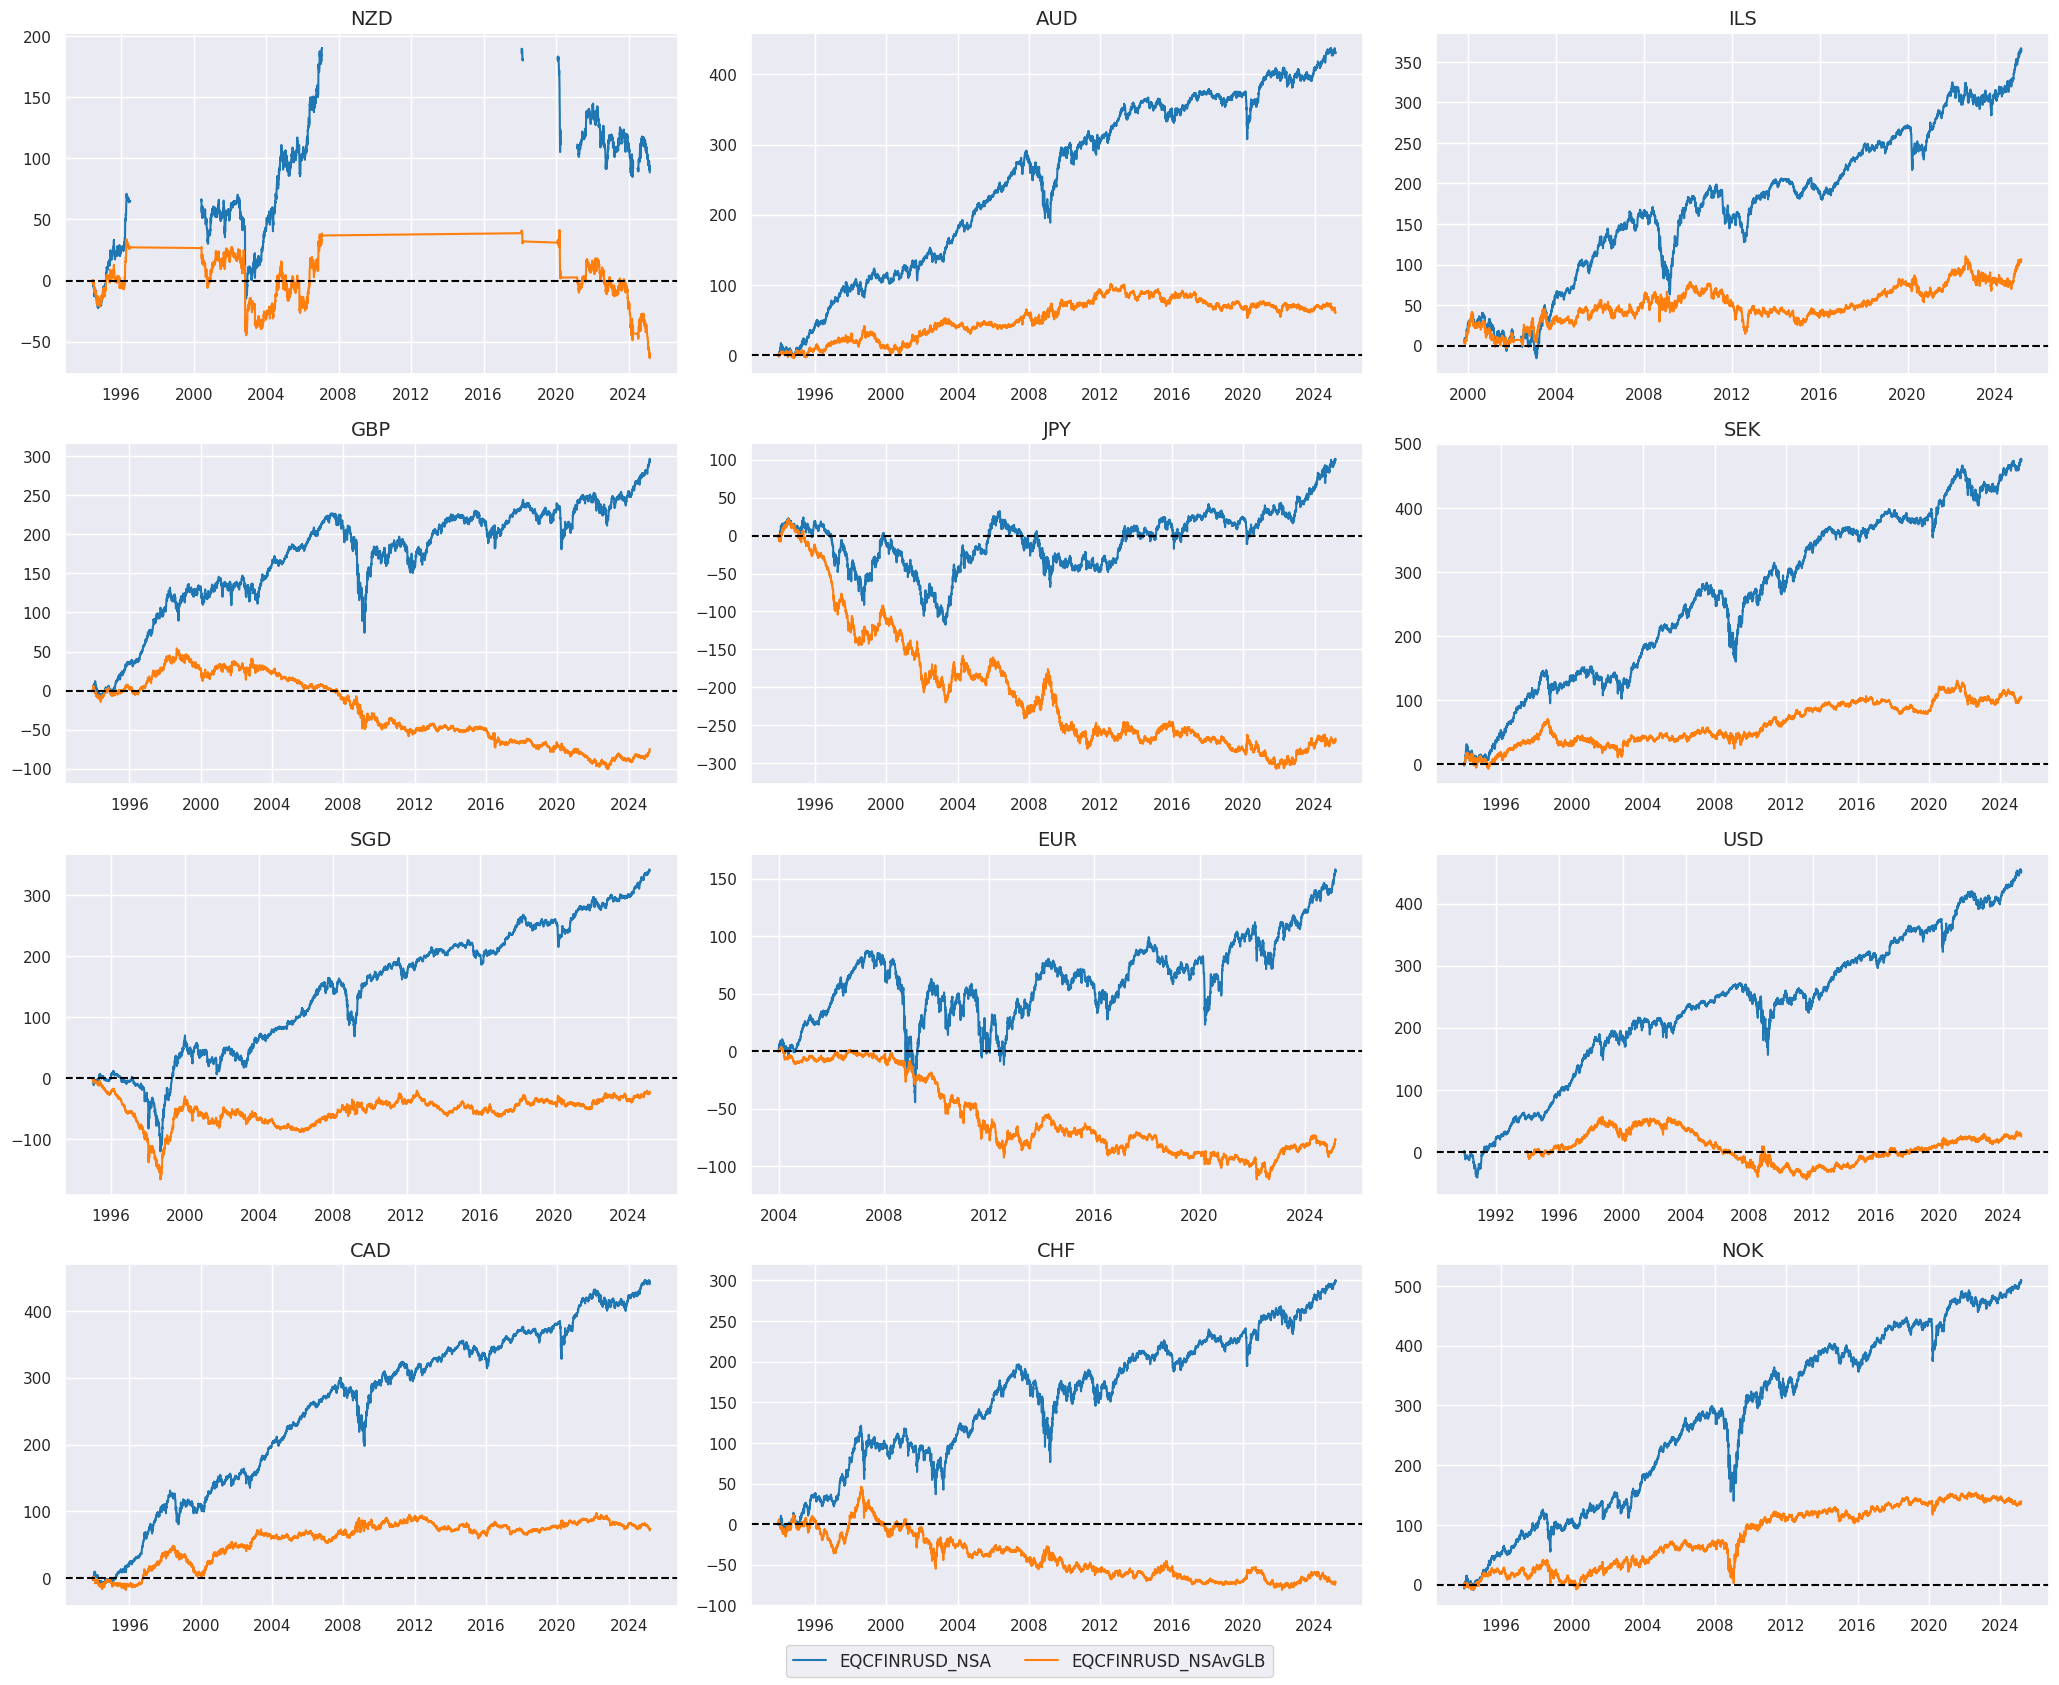

In [22]:
sec = "FIN"
xcatx = [f"EQC{sec}RUSD_NSA", f"EQC{sec}RUSD_NSAvGLB"]
cidx = cids_eqx
start_date = "1990-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start=start_date,
    cumsum=True,
    ncol=3,
    same_y=False,
    size=(12, 7),
    all_xticks=True,
    xcat_grid=False,
)

## Value checks

The notebook evaluates the predictive relations of quantamental indicators (standard and linear composite indicators) by means of panel regression, i.e., the joint consideration of macro trends and relative equity returns over a set of cross sections (currency areas or sectors). The notebook computes various metrics and ratios, including:

- Correlation: Measures the relationship between meaningful economic trends and  consequent equity cross-sector and cross-country returns. 

- Accuracy Metrics: These metrics assess the accuracy of the selectged indicators in predicting market movements. Common accuracy metrics include accuracy rate, balanced accuracy, precision etc.

The Value checks section is split into two parts:

The first part looks at allocation across sectors, within the same currency area. For example, some sectors are naturally more sensitive to growth, while others are more susceptible to financial conditions or inflation headwinds. This part considers a few plausible hypothesis:
-  strong excess export growth positively predicts the relative performance of the energy sector,
- positive business sentiment in services surveys predicts good subsequent business results in key services sectors, i.e., health care and utilities,
- High consumer confidence predicts real estate outperformance,
- High inflation predicts real estate underperformance.
        
The second part looks at the allocation across currency areas, particularly within the same sector. For real money investors such allocations typically involve both currency and pure equity risk. Relative economic trends, such as growth differentials, matter if they have significant predictive power for the joint currency or equity portion of the return and if cross-country divergences are common and sizable. This part considers a few plausible hypotheses:
- relative export growth positively predicts relative cross-country equity performance across various sectors,
- relative changes in business confidence score positively predict relative returns for industrial stocks as well as overall equity indices that include all sectors,
- a steeper real yield curve bodes for better returns for financial sector.


### Cross-sector allocations

JPMaQS quantamental indicators can be a relevant guide to building sectoral rotational strategies in the equity space. Here we provide a glance at some of the relationships that link pure macroeconomic trends to the sector outperformance vs the local region equity index. As we show, value can be extracted both from forward-looking metrics such as consumer, manufacturing, and service survey score as well as from point-in-time backward-looking measures of realised economic activity.

#### Export growth predicts energy sector outperformance

Deviation of production prices and volumes, as well as exports, above their natural growth trend, provides a strong case for global and local real growth, which is generally associated with positive energy demand growth. This creates the base for the energy equity sector's relative performance.

##### Specs and panel tests

Here, we create plausible excess growth indicator groups using [`panel_calculator()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#create-new-category-panels-with-panel-calculator) method. For example
- `EXPORTS_SA_P6M6ML6AR_XNGDP` denotes excess export growth, 
- `PPIH_NSA_P1M1ML12_XIT` is excess inflation based on producer price inflation


In [23]:
cidx = cids_eqx
calcs = []

ips = ["IP_SA_P3M3ML3AR", "IP_SA_P6M6ML6AR", "IP_SA_P1M1ML12_3MMA"]
for ip in ips:
    calcs += [f"{ip}_XGDP = {ip} - RGDP_SA_P1Q1QL4_20QMM"]
 #   calcs += [f"{ip}_XIGDP = {ip} - INTRGDP_NSA_P1M1ML12_3MMA"]

xps = ["EXPORTS_SA_P6M6ML6AR", "EXPORTS_SA_P1M1ML12_3MMA"]
for xp in xps:
    calcs += [f"{xp}_XNGDP = {xp} - RGDP_SA_P1Q1QL4_20QMM - INFTEFF_NSA"]

pps = ["PPIH_NSA_P1M1ML12", "PPIH_SA_P3M3ML3AR"]
for pp in pps:
    calcs += [f"{pp}_XIT = {pp} - INFTEFF_NSA"]

dfa = msp.panel_calculator(df=dfx, calcs=calcs, cids=cids_eqx)
dfx = msm.update_df(dfx, dfa)

In [24]:
cidx = cids_eqx
sigs = [
    "EXPORTS_SA_P1M1ML12_3MMA_XNGDP",
    "EXPORTS_SA_P6M6ML6AR_XNGDP",
    "IP_SA_P1M1ML12_3MMA_XGDP",
    "PPIH_NSA_P1M1ML12_XIT",
]
rets = ["EQCENRR_NSAvALL"]
start = "2000-01-01"

dict_exen = {
    "sigs": sigs,
    "rets": rets,
    "cidx": cidx,
    "start": start,
    "black": None,
    "srr": None,
    "pnls": None,
}

[`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function is used for quick visualization and analysis of two categories, in particular, 
  - Excess export growth `EXPORTS_SA_P1M1ML12_3MMA_XNGDP`, derived earlier, and 
  - subsequent energy sector returns versus the average of all sectors `EQCENRR_NSAvALL`
  
The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. It includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship. The analysis is done on a quarterly basis. 

EQCENRR_NSAvALL misses: ['CHF'].


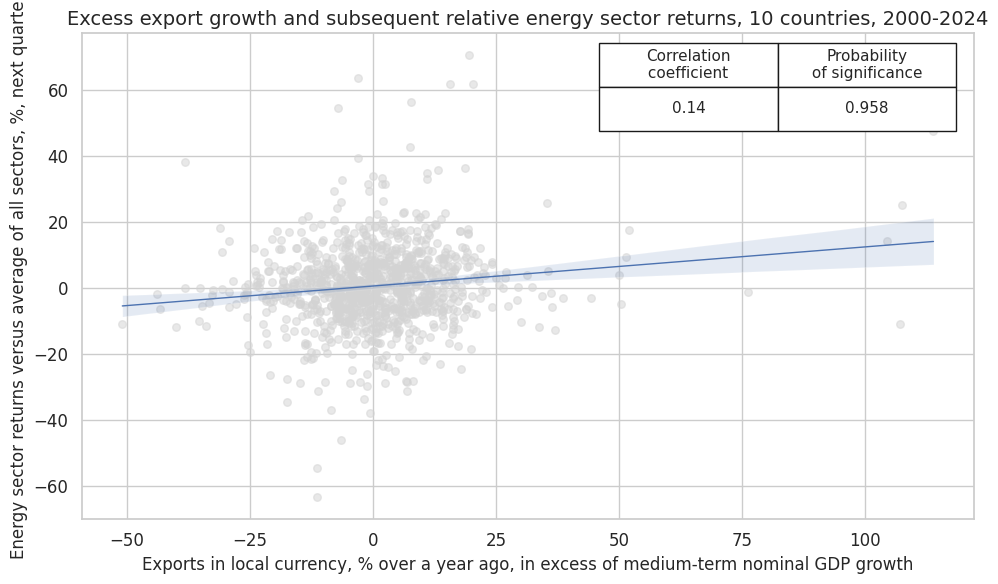

In [25]:
dix = dict_exen

sig = dix["sigs"][0]
ret = dix["rets"][0]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx_mat = msp.CategoryRelations(
    dfx,
    xcats=[sig, ret],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=None,
)
crx_mat.reg_scatter(
    labels=False,
    coef_box="upper right",
    xlab="Exports in local currency, % over a year ago, in excess of medium-term nominal GDP growth",
    ylab="Energy sector returns versus average of all sectors, %, next quarter",
    title="Excess export growth and subsequent relative energy sector returns, 10 countries, 2000-2024",
    size=(10, 6),
    prob_est="map",
)

##### Accuracy and correlation check

[`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) function from the `macrosynergy` package analyses and compares the relationships between the chosen signals and the panel of subsequent returns. There is no regression analysis involved, rather the sign of the signal is used for predicting the sign of the target.

In [26]:
dix = dict_exen

sigs = dix["sigs"]
rets = dix["rets"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=sigs,
    rets=rets,
    freqs="M",
    start=start,
    blacklist=blax,
)

dix["srr"] = srr

In [27]:
dix = dict_exen
srrx = dix["srr"]
xms = ["accuracy", "bal_accuracy", "pos_sigr", "pos_retr", "pearson", "pearson_pval", "kendall", "kendall_pval"]


The summary table below gives a short high-level snapshot of the strength and stability of the main signal and alternative signal relation. 

In [28]:
display(srrx.signals_table().sort_index().astype("float").round(3)[xms])

accuracy  \
Return          Signal                         Frequency Aggregation             
EQCENRR_NSAvALL EXPORTS_SA_P1M1ML12_3MMA_XNGDP M         last            0.536   
                EXPORTS_SA_P6M6ML6AR_XNGDP     M         last            0.518   
                IP_SA_P1M1ML12_3MMA_XGDP       M         last            0.522   
                PPIH_NSA_P1M1ML12_XIT          M         last            0.524   

                                                                      bal_accuracy  \
Return          Signal                         Frequency Aggregation                 
EQCENRR_NSAvALL EXPORTS_SA_P1M1ML12_3MMA_XNGDP M         last                0.536   
                EXPORTS_SA_P6M6ML6AR_XNGDP     M         last                0.518   
                IP_SA_P1M1ML12_3MMA_XGDP       M         last                0.522   
                PPIH_NSA_P1M1ML12_XIT          M         last                0.524   

                                                                      pos_sigr  \
Return          Signal                         Frequency Aggregation             
EQCENRR_NSAvALL EXPORTS_SA_P1M1ML12_3MMA_XNGDP M         last            0.491   
                EXPORTS_SA_P6M6ML6AR_XNGDP     M         last            0.498   
                IP_SA_P1M1ML12_3MMA_XGDP       M         last            0.361   
                PPIH_NSA_P1M1ML12_XIT          M         last            0.507   

                                                                      pos_retr  \
Return          Signal                         Frequency Aggregation             
EQCENRR_NSAvALL EXPORTS_SA_P1M1ML12_3MMA_XNGDP M         last            0.493   
                EXPORTS_SA_P6M6ML6AR_XNGDP     M         last            0.493   
                IP_SA_P1M1ML12_3MMA_XGDP       M         last            0.494   
                PPIH_NSA_P1M1ML12_XIT          M         last            0.493   

                                                                      pearson  \
Return          Signal                         Frequency Aggregation            
EQCENRR_NSAvALL EXPORTS_SA_P1M1ML12_3MMA_XNGDP M         last           0.105   
                EXPORTS_SA_P6M6ML6AR_XNGDP     M         last           0.085   
                IP_SA_P1M1ML12_3MMA_XGDP       M         last           0.055   
                PPIH_NSA_P1M1ML12_XIT          M         last           0.095   

                                                                      pearson_pval  \
Return          Signal                         Frequency Aggregation                 
EQCENRR_NSAvALL EXPORTS_SA_P1M1ML12_3MMA_XNGDP M         last                0.000   
                EXPORTS_SA_P6M6ML6AR_XNGDP     M         last                0.000   
                IP_SA_P1M1ML12_3MMA_XGDP       M         last                0.002   
                PPIH_NSA_P1M1ML12_XIT          M         last                0.000   

                                                                      kendall  \
Return          Signal                         Frequency Aggregation            
EQCENRR_NSAvALL EXPORTS_SA_P1M1ML12_3MMA_XNGDP M         last           0.055   
                EXPORTS_SA_P6M6ML6AR_XNGDP     M         last           0.042   
                IP_SA_P1M1ML12_3MMA_XGDP       M         last           0.031   
                PPIH_NSA_P1M1ML12_XIT          M         last           0.039   

                                                                      kendall_pval  
Return          Signal                         Frequency Aggregation                
EQCENRR_NSAvALL EXPORTS_SA_P1M1ML12_3MMA_XNGDP M         last                0.000  
                EXPORTS_SA_P6M6ML6AR_XNGDP     M         last                0.000  
                IP_SA_P1M1ML12_3MMA_XGDP       M         last                0.010  
                PPIH_NSA_P1M1ML12_XIT          M         last                0.001

#### High services sentiment predicts outperformance of health care and utilities stocks

The service industry expectations are positively correlated with measures of economic growth. As we show below,  the level of service sentiment and higher frequency nowcasted real growth rates go hand in hand. The quantamental indicators are relatively forward-looking measurements, with little release lag so accurately reflect the state of the economy.

This is helpful in identifying turning points for the relative performance of more defensive, less cyclical sectors such as utilities and healthcare stocks. These show a strong positive relationship with the selected quantamental indicators over quarterly frequency.

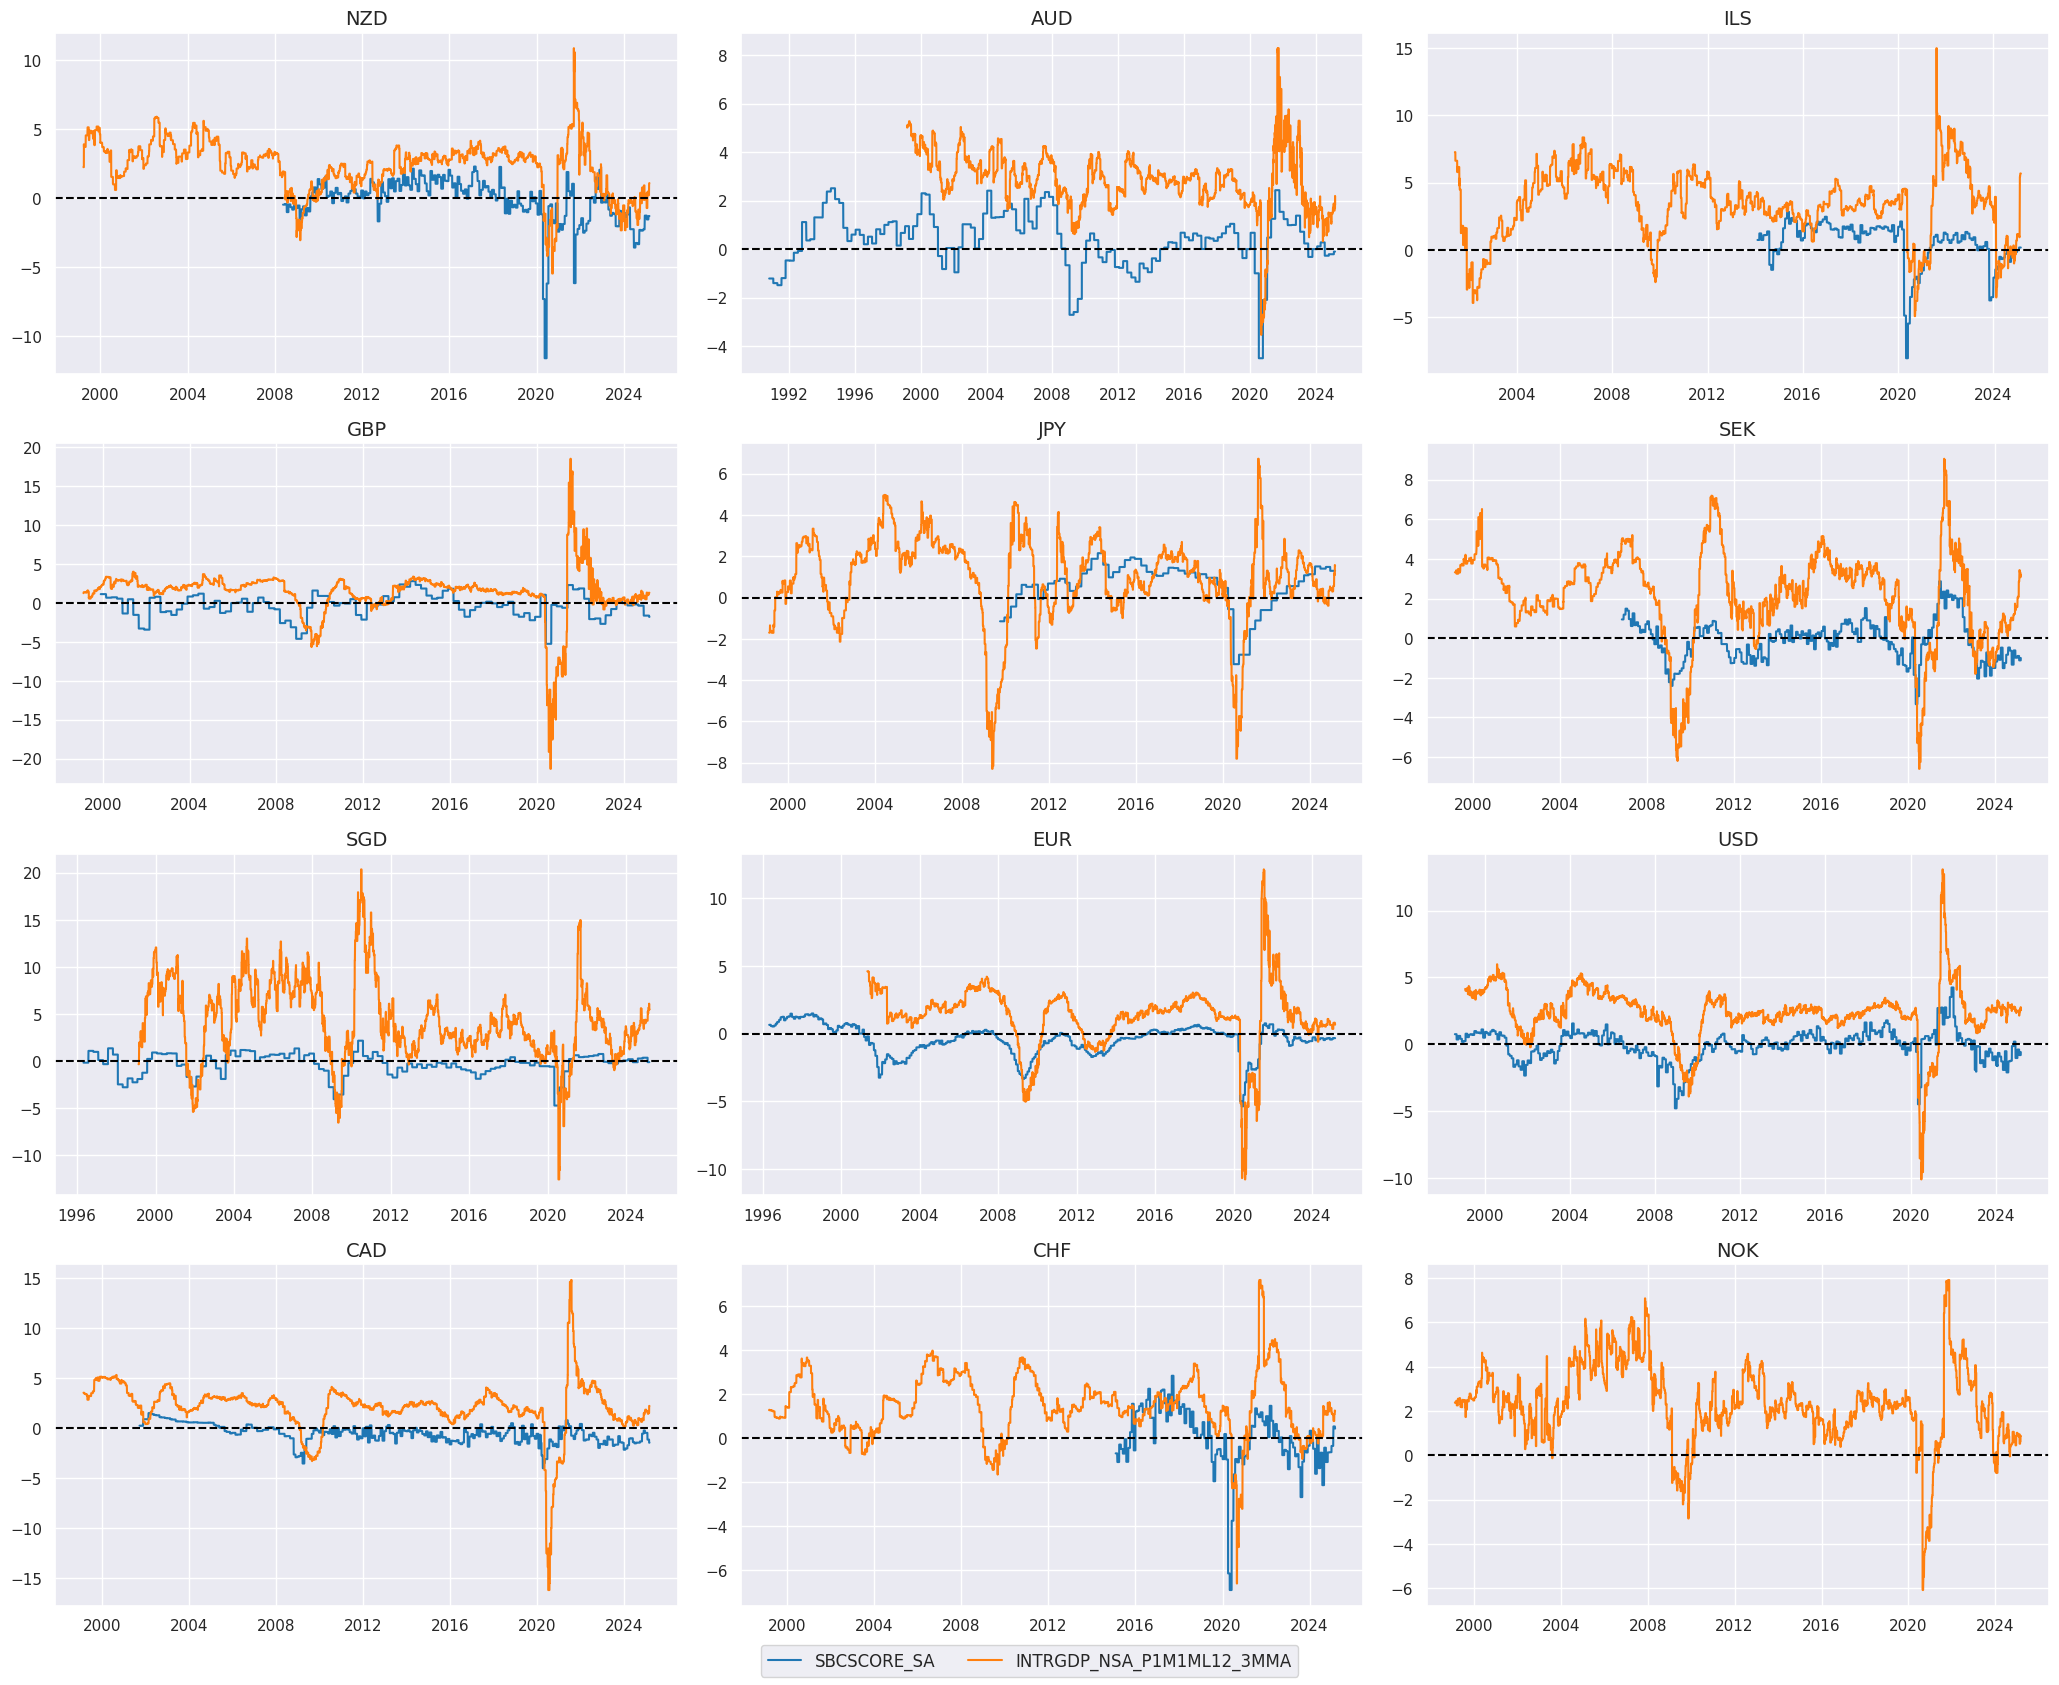

In [29]:
xcatx = ["SBCSCORE_SA", "INTRGDP_NSA_P1M1ML12_3MMA"]
cidx = cids_eqx
start_date = "1990-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start=start_date,
    cumsum=False,
    ncol=3,
    same_y=False,
    size=(12, 7),
    all_xticks=True,
    xcat_grid=False,
)

##### Specs and panel tests

In [30]:
cidx = cids_eqx
sigs = ["SBCSCORE_SA", "SBCSCORE_SA_D3M3ML3"]
rets = ["EQCHLCR_NSAvALL", "EQCUTLR_NSAvALL"]
start = "2000-01-01"

dict_sshu = {
    "sigs": sigs,
    "rets": rets,
    "cidx": cidx,
    "start": start,
    "black": None,
    "srr": None,
    "pnls": None,
}

[`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function is used for quick visualization and analysis of two categories, in particular, 
  - Services confidence scores `SBCSCORE_SA`, and 
  - subsequent relative health care returns `EQCHLCR_NSAvALL`
  
The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. It includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship. The analysis is done on a quarterly basis. 

SBCSCORE_SA misses: ['NOK'].


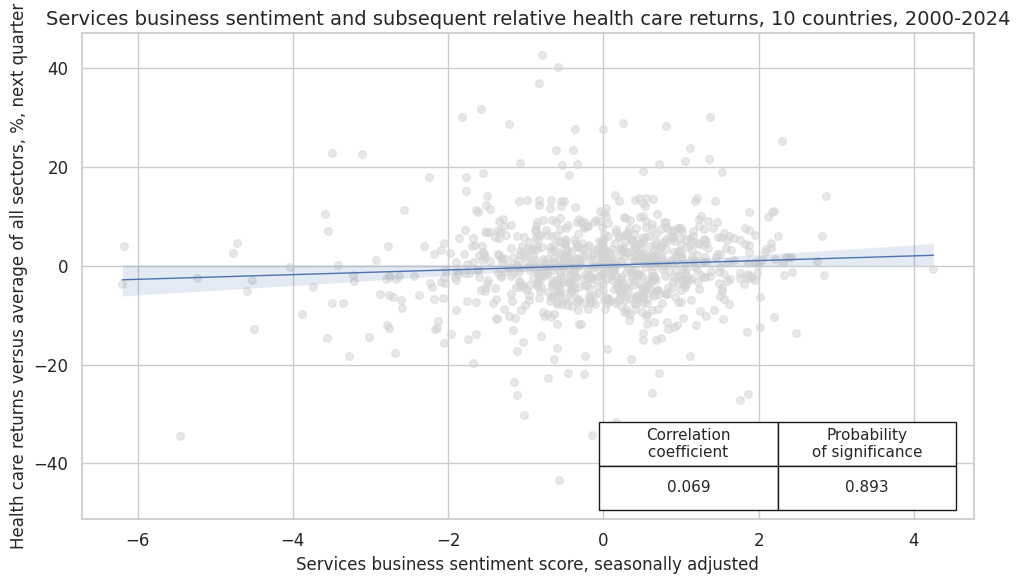

In [31]:
dix = dict_sshu

sig = dix["sigs"][0]
ret = dix["rets"][0]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx_mat = msp.CategoryRelations(
    dfx,
    xcats=[sig, ret],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=None,
    xcat_trims=[10, 50]  # adjust for extreme > 10 SD outlier
)
crx_mat.reg_scatter(
    labels=False,
    coef_box="lower right",
    xlab="Services business sentiment score, seasonally adjusted",
    ylab="Health care returns versus average of all sectors, %, next quarter",
    title="Services business sentiment and subsequent relative health care returns, 10 countries, 2000-2024",
    size=(10, 6),
    prob_est="map",
)

[`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function is used for quick visualization and analysis of two categories. Her it analyses
  - services confidence scores `SBCSCORE_SA`, and 
  - subsequent utilities returns versus average of all sectors `EQCHLCR_NSAvALL` 
  
The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. It includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship. The analysis is done on a quarterly basis. 

SBCSCORE_SA misses: ['NOK'].


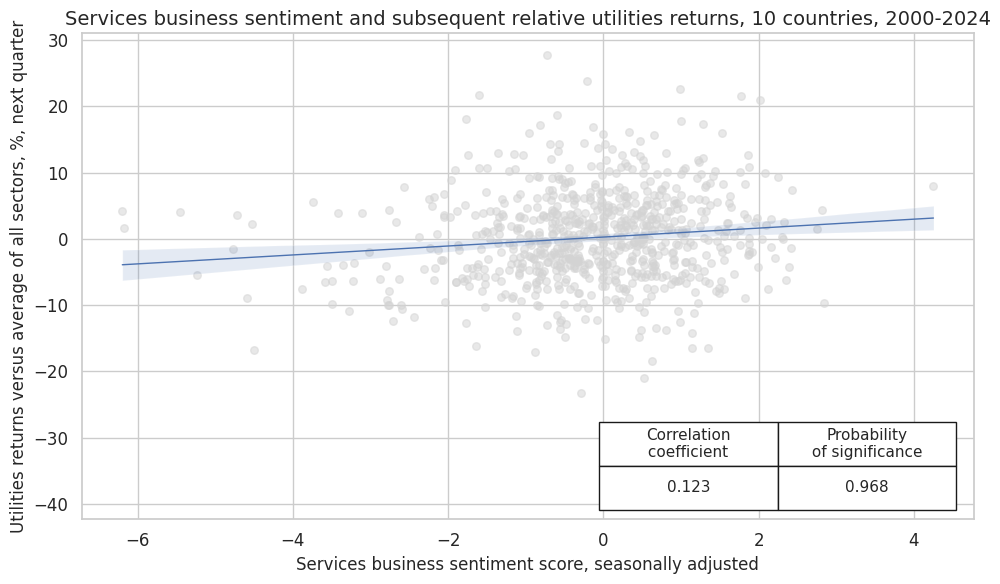

In [32]:
dix = dict_sshu

sig = dix["sigs"][0]
ret = dix["rets"][1]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx_mat = msp.CategoryRelations(
    dfx,
    xcats=[sig, ret],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=None,
    xcat_trims=[10, 50]  # adjust for extreme > 10 SD outlier
)
crx_mat.reg_scatter(
    labels=False,
    coef_box="lower right",
    xlab="Services business sentiment score, seasonally adjusted",
    ylab="Utilities returns versus average of all sectors, %, next quarter",
    title="Services business sentiment and subsequent relative utilities returns, 10 countries, 2000-2024",
    size=(10, 6),
    prob_est="map",
)

##### Accuracy and correlation check

[`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) function from the `macrosynergy` package analyses and compares the relationships between the chosen signals and the panel of subsequent returns. There is no regression analysis involved, rather the sign of the signal is used for predicting the sign of the target.

In [33]:
dix = dict_sshu

sigs = dix["sigs"]
rets = dix["rets"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    df=dfx,
    cids=cidx,
    sigs=sigs,
    rets=rets,
    freqs="M",
    start="1995-01-01",
)

mrt = srr.multiple_relations_table(rets=rets, xcats=sigs)


In [34]:

display(mrt.sort_index().astype("float").round(3)[xms])

accuracy  \
Return          Signal              Frequency Aggregation             
EQCHLCR_NSAvALL SBCSCORE_SA         M         last            0.510   
                SBCSCORE_SA_D3M3ML3 M         last            0.500   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last            0.531   
                SBCSCORE_SA_D3M3ML3 M         last            0.514   

                                                           bal_accuracy  \
Return          Signal              Frequency Aggregation                 
EQCHLCR_NSAvALL SBCSCORE_SA         M         last                0.510   
                SBCSCORE_SA_D3M3ML3 M         last                0.500   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last                0.531   
                SBCSCORE_SA_D3M3ML3 M         last                0.514   

                                                           pos_sigr  pos_retr  \
Return          Signal              Frequency Aggregation                       
EQCHLCR_NSAvALL SBCSCORE_SA         M         last            0.513     0.507   
                SBCSCORE_SA_D3M3ML3 M         last            0.500     0.505   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last            0.502     0.511   
                SBCSCORE_SA_D3M3ML3 M         last            0.503     0.509   

                                                           pearson  \
Return          Signal              Frequency Aggregation            
EQCHLCR_NSAvALL SBCSCORE_SA         M         last           0.026   
                SBCSCORE_SA_D3M3ML3 M         last           0.003   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last           0.054   
                SBCSCORE_SA_D3M3ML3 M         last           0.012   

                                                           pearson_pval  \
Return          Signal              Frequency Aggregation                 
EQCHLCR_NSAvALL SBCSCORE_SA         M         last                0.174   
                SBCSCORE_SA_D3M3ML3 M         last                0.887   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last                0.008   
                SBCSCORE_SA_D3M3ML3 M         last                0.573   

                                                           kendall  \
Return          Signal              Frequency Aggregation            
EQCHLCR_NSAvALL SBCSCORE_SA         M         last           0.024   
                SBCSCORE_SA_D3M3ML3 M         last          -0.005   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last           0.043   
                SBCSCORE_SA_D3M3ML3 M         last           0.012   

                                                           kendall_pval  
Return          Signal              Frequency Aggregation                
EQCHLCR_NSAvALL SBCSCORE_SA         M         last                0.056  
                SBCSCORE_SA_D3M3ML3 M         last                0.716  
EQCUTLR_NSAvALL SBCSCORE_SA         M         last                0.002  
                SBCSCORE_SA_D3M3ML3 M         last                0.370

#### High consumer confidence predicts real estate outperformance

Here the idea is that strong household sentiment fosters particular demand for residential real estate. Moreover, circumstances that support household confidence, such as low inflation and low real interest rates also support demand for housing.

##### Specs and panel test

In [35]:
cidx = cids_eqx
sigs = ["CCSCORE_SA", "CCSCORE_SA_D3M3ML3"]
rets = ["EQCRELR_NSAvALL"]
start = "2000-01-01"

dict_ccre = {
    "sigs": sigs,
    "rets": rets,
    "cidx": cidx,
    "start": start,
    "black": None,
    "srr": None,
    "pnls": None,
}

[`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function is used for quick visualization and analysis of two categories. Her it analyses
  - consumer confidence scores `CCSCORE_SA`, and 
  - subsequent relative real estate returns `EQCRELR_NSAvALL`
  
The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. It includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship. The analysis is done on a quarterly basis. 

CCSCORE_SA misses: ['SGD'].


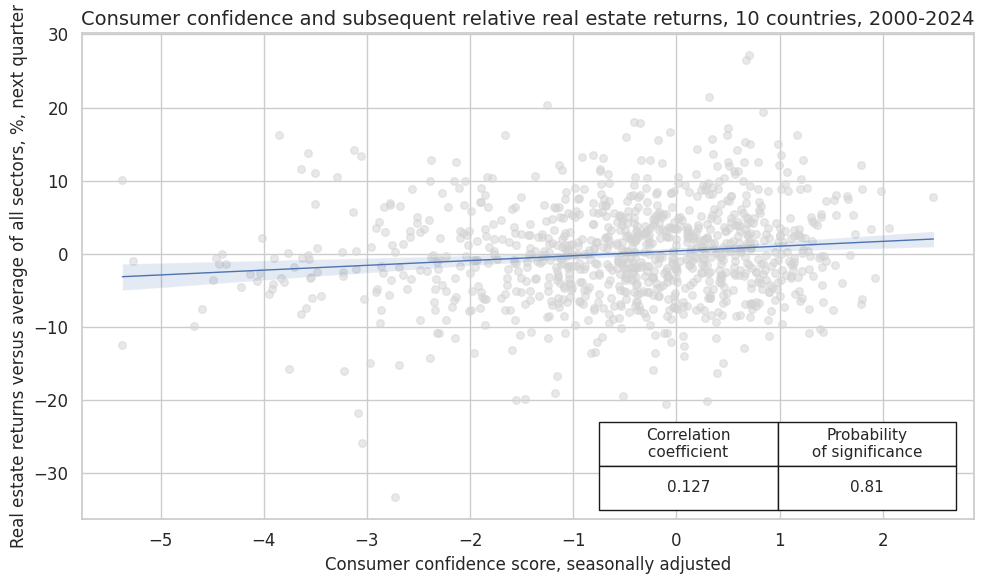

In [36]:
dix = dict_ccre

sig = dix["sigs"][0]
ret = dix["rets"][0]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx_mat = msp.CategoryRelations(
    dfx,
    xcats=[sig, ret],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=None,
)
crx_mat.reg_scatter(
    labels=False,
    coef_box="lower right",
    xlab="Consumer confidence score, seasonally adjusted",
    ylab="Real estate returns versus average of all sectors, %, next quarter",
    title="Consumer confidence and subsequent relative real estate returns, 10 countries, 2000-2024",
    size=(10, 6),
    prob_est="map",
)

##### Accuracy and correlation check

[`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) function from the `macrosynergy` package analyses and compares the relationships between the chosen signals and the panel of subsequent returns. There is no regression analysis involved, rather the sign of the signal is used for predicting the sign of the target.

In [37]:
dix = dict_ccre

sigs = dix["sigs"]
rets = dix["rets"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    df=dfx,
    cids=cidx,
    sigs=sigs,
    rets=rets,
    freqs="M",
    start="1995-01-01",
)




In [38]:
display(mrt.sort_index().astype("float").round(3)[xms])

accuracy  \
Return          Signal              Frequency Aggregation             
EQCHLCR_NSAvALL SBCSCORE_SA         M         last            0.510   
                SBCSCORE_SA_D3M3ML3 M         last            0.500   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last            0.531   
                SBCSCORE_SA_D3M3ML3 M         last            0.514   

                                                           bal_accuracy  \
Return          Signal              Frequency Aggregation                 
EQCHLCR_NSAvALL SBCSCORE_SA         M         last                0.510   
                SBCSCORE_SA_D3M3ML3 M         last                0.500   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last                0.531   
                SBCSCORE_SA_D3M3ML3 M         last                0.514   

                                                           pos_sigr  pos_retr  \
Return          Signal              Frequency Aggregation                       
EQCHLCR_NSAvALL SBCSCORE_SA         M         last            0.513     0.507   
                SBCSCORE_SA_D3M3ML3 M         last            0.500     0.505   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last            0.502     0.511   
                SBCSCORE_SA_D3M3ML3 M         last            0.503     0.509   

                                                           pearson  \
Return          Signal              Frequency Aggregation            
EQCHLCR_NSAvALL SBCSCORE_SA         M         last           0.026   
                SBCSCORE_SA_D3M3ML3 M         last           0.003   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last           0.054   
                SBCSCORE_SA_D3M3ML3 M         last           0.012   

                                                           pearson_pval  \
Return          Signal              Frequency Aggregation                 
EQCHLCR_NSAvALL SBCSCORE_SA         M         last                0.174   
                SBCSCORE_SA_D3M3ML3 M         last                0.887   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last                0.008   
                SBCSCORE_SA_D3M3ML3 M         last                0.573   

                                                           kendall  \
Return          Signal              Frequency Aggregation            
EQCHLCR_NSAvALL SBCSCORE_SA         M         last           0.024   
                SBCSCORE_SA_D3M3ML3 M         last          -0.005   
EQCUTLR_NSAvALL SBCSCORE_SA         M         last           0.043   
                SBCSCORE_SA_D3M3ML3 M         last           0.012   

                                                           kendall_pval  
Return          Signal              Frequency Aggregation                
EQCHLCR_NSAvALL SBCSCORE_SA         M         last                0.056  
                SBCSCORE_SA_D3M3ML3 M         last                0.716  
EQCUTLR_NSAvALL SBCSCORE_SA         M         last                0.002  
                SBCSCORE_SA_D3M3ML3 M         last                0.370

#### High inflation predicts real estate underperformance

Real estate equity sector includes both [REITs businesses](https://en.wikipedia.org/wiki/Real_estate_investment_trust) and real estate development companies. Even if the economic nature of the activity is slightly different, the two sets of companies operate with high leverage and would be naturally affected by changes in interest rates. The excess core inflation indicators are a strong predictor of future rates movement, therefore they are applicable in this case.

##### Specs and panel tests

In [39]:
for cpi in ["CPIC_SA_P1M1ML12", "CPIC_SJA_P3M3ML3AR"]:
    calcs += [f"{cpi}_XIT = {cpi} - INFTEFF_NSA"]
dfa = msp.panel_calculator(df=dfx, calcs=calcs, cids=cids_eqx)
dfx = msm.update_df(dfx, dfa)

In [40]:
cidx = cids_eqx
sigs = ["CPIC_SA_P1M1ML12_XIT", "CPIC_SJA_P3M3ML3AR_XIT"]
rets = ["EQCRELR_NSAvALL"]
start = "2000-01-01"

dict_cpre = {
    "sigs": sigs,
    "rets": rets,
    "cidx": cidx,
    "start": start,
    "black": None,
    "srr": None,
    "pnls": None,
}

[`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function is used for quick visualization and analysis of two categories. Her it analyses
  - Core CPI inflation in excess of effective inflation target `CPIC_SA_P1M1ML12_XIT`, and 
  - Real estate returns versus average of all sectors `EQCRELR_NSAvALL` 
  
The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. It includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship. The analysis is done on a quarterly basis. 

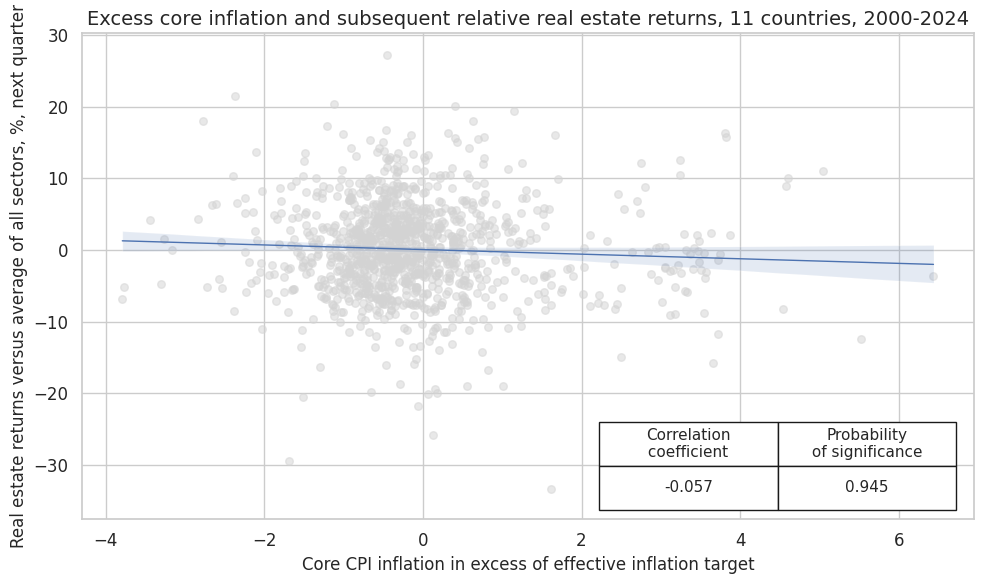

In [41]:
dix = dict_cpre

sig = dix["sigs"][0]
ret = dix["rets"][0]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx_mat = msp.CategoryRelations(
    dfx,
    xcats=[sig, ret],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=None,
)
crx_mat.reg_scatter(
    labels=False,
    coef_box="lower right",
    xlab="Core CPI inflation in excess of effective inflation target",
    ylab="Real estate returns versus average of all sectors, %, next quarter",
    title="Excess core inflation and subsequent relative real estate returns, 11 countries, 2000-2024",
    size=(10, 6),
    prob_est="pool",
)

##### Accuracy and correlation check

[`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) function from the `macrosynergy` package analyses and compares the relationships between the chosen signals and the panel of subsequent returns. There is no regression analysis involved, rather the sign of the signal is used for predicting the sign of the target.

In [42]:
dix = dict_cpre

sigs = dix["sigs"]
rets = dix["rets"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    df=dfx,
    cids=cidx,
    sigs=sigs,
    rets=rets,
    freqs="M",
    start="1995-01-01",
)

mrt = srr.multiple_relations_table(rets=rets, xcats=sigs)


In [43]:
display(mrt.sort_index().astype("float").round(3)[xms])

accuracy  \
Return          Signal                 Frequency Aggregation             
EQCRELR_NSAvALL CPIC_SA_P1M1ML12_XIT   M         last            0.500   
                CPIC_SJA_P3M3ML3AR_XIT M         last            0.499   

                                                              bal_accuracy  \
Return          Signal                 Frequency Aggregation                 
EQCRELR_NSAvALL CPIC_SA_P1M1ML12_XIT   M         last                0.497   
                CPIC_SJA_P3M3ML3AR_XIT M         last                0.498   

                                                              pos_sigr  \
Return          Signal                 Frequency Aggregation             
EQCRELR_NSAvALL CPIC_SA_P1M1ML12_XIT   M         last            0.325   
                CPIC_SJA_P3M3ML3AR_XIT M         last            0.398   

                                                              pos_retr  \
Return          Signal                 Frequency Aggregation             
EQCRELR_NSAvALL CPIC_SA_P1M1ML12_XIT   M         last            0.494   
                CPIC_SJA_P3M3ML3AR_XIT M         last            0.494   

                                                              pearson  \
Return          Signal                 Frequency Aggregation            
EQCRELR_NSAvALL CPIC_SA_P1M1ML12_XIT   M         last          -0.034   
                CPIC_SJA_P3M3ML3AR_XIT M         last          -0.040   

                                                              pearson_pval  \
Return          Signal                 Frequency Aggregation                 
EQCRELR_NSAvALL CPIC_SA_P1M1ML12_XIT   M         last                0.041   
                CPIC_SJA_P3M3ML3AR_XIT M         last                0.017   

                                                              kendall  \
Return          Signal                 Frequency Aggregation            
EQCRELR_NSAvALL CPIC_SA_P1M1ML12_XIT   M         last          -0.010   
                CPIC_SJA_P3M3ML3AR_XIT M         last          -0.006   

                                                              kendall_pval  
Return          Signal                 Frequency Aggregation                
EQCRELR_NSAvALL CPIC_SA_P1M1ML12_XIT   M         last                0.379  
                CPIC_SJA_P3M3ML3AR_XIT M         last                0.602

### Intra-sector cross-country allocations

Another potential use case of JPMaQS quantamental indicators is presented by cross-country equity allocation for given sectors. 
In similar fashion to what built above, we link both backward and forward looking macroeconomic variables to relative equity performance.

#### Stronger export growth predicts country outperformance, marketwide and for some sectors

With a similar approach to the previous case, relative positive/negative export trends across countries are a manifestation of improving / degrading relative conditions of the local economy. This provides the basis for relative trades of USD-denominated local equity indices and more cyclical sectors such as energy and industrials.

##### Specs and panel tests

In [44]:
cidx = cids_eqx
xcatx = ["EXPORTS_SA_P6M6ML6AR", "EXPORTS_SA_P1M1ML12_3MMA"]

dfa = msp.make_relative_value(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start="1990-01-01",
    rel_meth="subtract",
    postfix="vGLB",
)

dfx = msm.update_df(dfx, dfa)

In [45]:
cidx = cids_eqx
sigs = [
    "EXPORTS_SA_P1M1ML12_3MMAvGLB",
    "EXPORTS_SA_P6M6ML6ARvGLB",
]
rets = ["EQCALLRUSD_NSAvGLB", "EQCENRRUSD_NSAvGLB", "EQCINDRUSD_NSAvGLB"]
start = "2000-01-01"

dict_exxc = {
    "sigs": sigs,
    "rets": rets,
    "cidx": cidx,
    "start": start,
    "black": None,
    "srr": None,
    "pnls": None,
}

[`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function is used for quick visualization and analysis of two categories. Here it analyses
  - Export growth in local currency, % over a year ago, relative to all countries' average `EXPORTS_SA_P1M1ML12_3MMAvGLB`, and 
  - subsequent USD equity index returns vs. all countries `EQCALLRUSD_NSAvGLB` 
  
The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. It includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship. The analysis is done on a quarterly basis. 

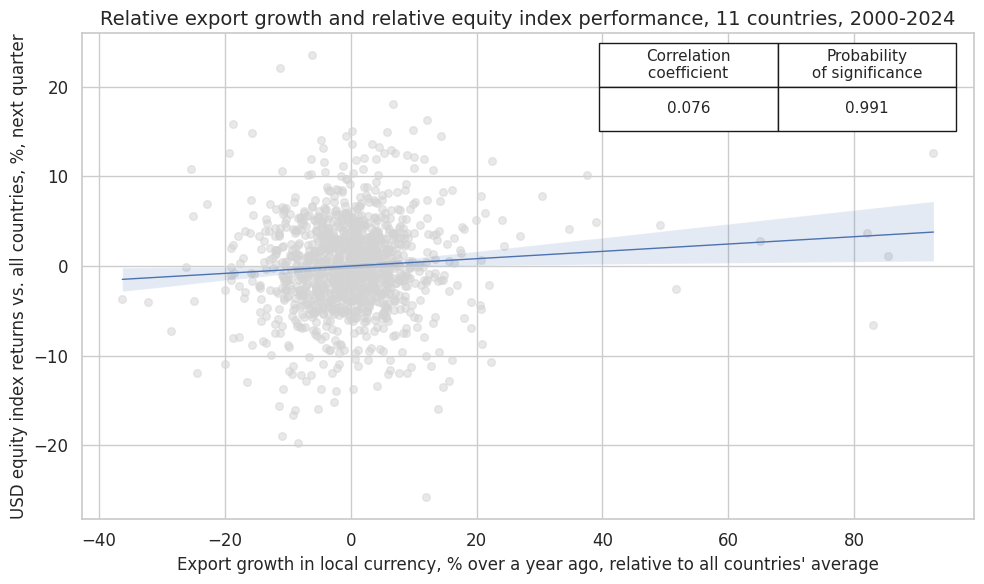

In [46]:
dix = dict_exxc

sig = dix["sigs"][0]
ret = dix["rets"][0]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx_mat = msp.CategoryRelations(
    dfx,
    xcats=[sig, ret],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=None,
)
crx_mat.reg_scatter(
    labels=False,
    coef_box="upper right",
    xlab="Export growth in local currency, % over a year ago, relative to all countries' average",
    ylab="USD equity index returns vs. all countries, %, next quarter",
    title="Relative export growth and relative equity index performance, 11 countries, 2000-2024",
    size=(10, 6),
    prob_est="map",
)

##### Accuracy and correlation check

[`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) function from the `macrosynergy` package analyses and compares the relationships between the chosen signals and the panel of subsequent returns. There is no regression analysis involved, rather the sign of the signal is used for predicting the sign of the target.

In [47]:
dix = dict_exxc

sigs = dix["sigs"]
rets = dix["rets"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    df=dfx,
    cids=cidx,
    sigs=sigs,
    rets=rets,
    freqs="M",
    start="1995-01-01",
)

mrt = srr.multiple_relations_table(rets=rets, xcats=sigs)


In [48]:
display(mrt.sort_index().astype("float").round(3)[xms])

accuracy  \
Return             Signal                       Frequency Aggregation             
EQCALLRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last            0.511   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last            0.499   
EQCENRRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last            0.510   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last            0.510   
EQCINDRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last            0.516   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last            0.507   

                                                                       bal_accuracy  \
Return             Signal                       Frequency Aggregation                 
EQCALLRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last                0.511   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last                0.499   
EQCENRRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last                0.510   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last                0.509   
EQCINDRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last                0.517   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last                0.507   

                                                                       pos_sigr  \
Return             Signal                       Frequency Aggregation             
EQCALLRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last            0.470   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last            0.462   
EQCENRRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last            0.467   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last            0.465   
EQCINDRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last            0.470   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last            0.462   

                                                                       pos_retr  \
Return             Signal                       Frequency Aggregation             
EQCALLRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last            0.499   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last            0.499   
EQCENRRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last            0.493   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last            0.493   
EQCINDRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last            0.507   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last            0.507   

                                                                       pearson  \
Return             Signal                       Frequency Aggregation            
EQCALLRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last           0.040   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last           0.036   
EQCENRRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last           0.034   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last           0.031   
EQCINDRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last           0.025   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last           0.025   

                                                                       pearson_pval  \
Return             Signal                       Frequency Aggregation                 
EQCALLRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last                0.011   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last                0.022   
EQCENRRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last                0.045   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last                0.074   
EQCINDRUSD_NSAvGLB EXPORTS_SA_P1M1ML12_3MMAvGLB M         last                0.108   
                   EXPORTS_SA_P6M6ML6ARvGLB     M         last                0.109   

                         

#### Manufacturing confidence changes predict country outperformance, marketwide and for many sectors

Relative changes in manufacturing business confidence scores should positively predict the relative performance of manufacturing businesses across countries and, by extension, the relative performance of equity returns for the industrial sector and maybe even the overall business sector. 

##### Specs and panel tests

Here we calculate the relative value of manufacturing confidence scores and give them postfix `vGLB` to indicate "versus Global Benchmark".

In [49]:
cidx = cids_eqx
xcatx = ["MBCSCORE_SA_D3M3ML3", "MBCSCORE_SA"]

dfa = msp.make_relative_value(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start="1990-01-01",
    rel_meth="subtract",
    postfix="vGLB",
)

dfx = msm.update_df(dfx, dfa)

In [50]:
cidx = cids_eqx
sigs = [
    "MBCSCORE_SA_D3M3ML3vGLB",
    "MBCSCORE_SAvGLB",
]
rets = [
    "EQCALLRUSD_NSAvGLB",
    "EQCCSRRUSD_NSAvGLB",
    "EQCCOSRUSD_NSAvGLB",
    "EQCINDRUSD_NSAvGLB",
]
start = "2000-01-01"

dict_mcxc = {
    "sigs": sigs,
    "rets": rets,
    "cidx": cidx,
    "start": start,
    "black": None,
    "srr": None,
    "pnls": None,
}

[`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function is used for quick visualization and analysis of two categories, in particular, 
  - Relative manufacturing survey score `MBCSCORE_SA_D3M3ML3vGLB`, and 
  - subsequent relative equity returns `EQCALLRUSD_NSAvGLB`
  
The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. It includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship. The analysis is done on a quarterly basis. 

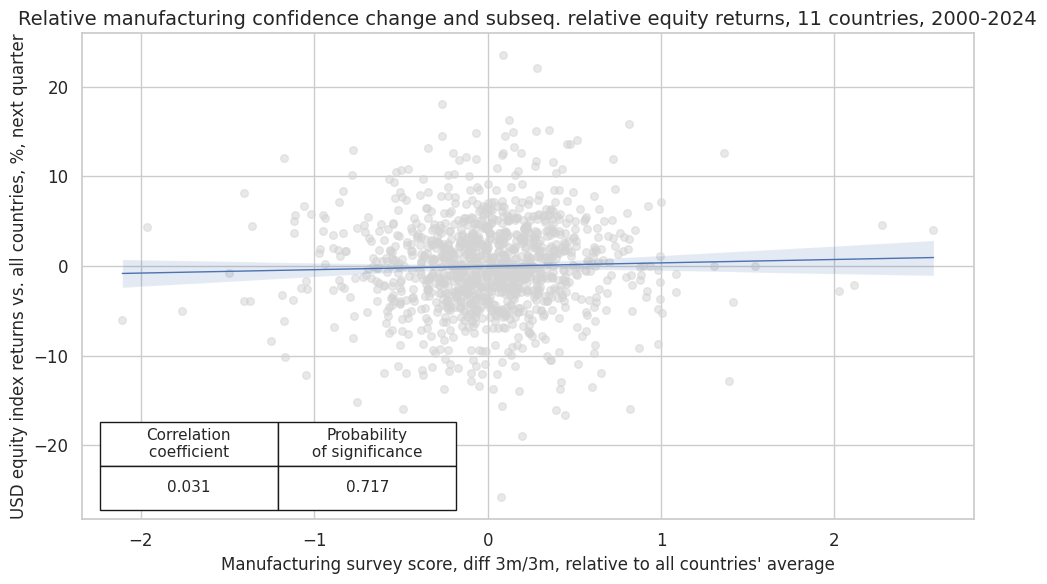

In [51]:
dix = dict_mcxc

sig = dix["sigs"][0]
ret = dix["rets"][0]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx_mat = msp.CategoryRelations(
    dfx,
    xcats=[sig, ret],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=None,
)
crx_mat.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Manufacturing survey score, diff 3m/3m, relative to all countries' average",
    ylab="USD equity index returns vs. all countries, %, next quarter",
    title="Relative manufacturing confidence change and subseq. relative equity returns, 11 countries, 2000-2024",
    size=(10, 6),
    prob_est="map",
)

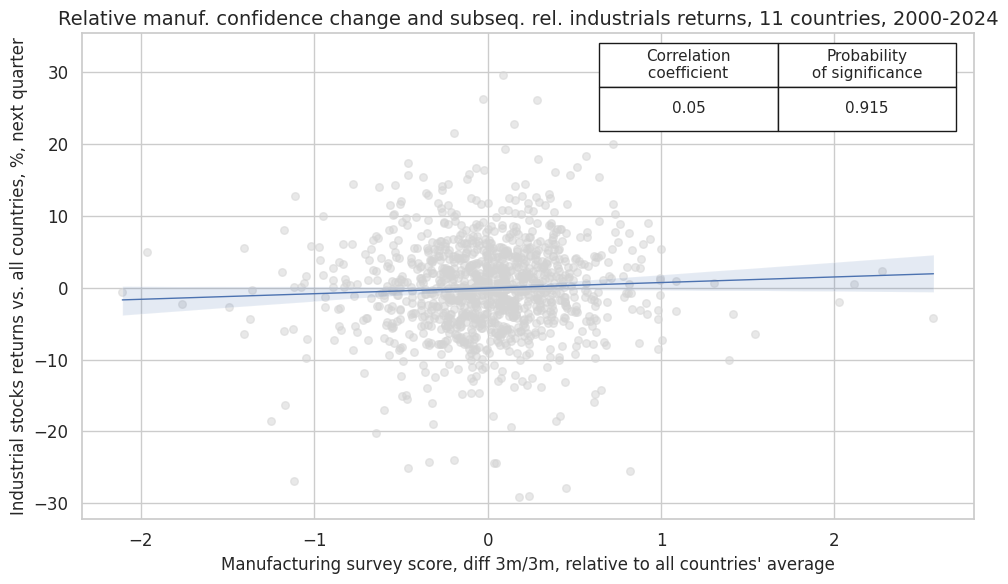

In [52]:
dix = dict_mcxc

sig = dix["sigs"][0]
ret = dix["rets"][3]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx_mat = msp.CategoryRelations(
    dfx,
    xcats=[sig, ret],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=None,
)
crx_mat.reg_scatter(
    labels=False,
    coef_box="upper right",
    xlab="Manufacturing survey score, diff 3m/3m, relative to all countries' average",
    ylab="Industrial stocks returns vs. all countries, %, next quarter",
    title="Relative manuf. confidence change and subseq. rel. industrials returns, 11 countries, 2000-2024",
    size=(10, 6),
    prob_est="map",
)

##### Accuracy and correlation check

[`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) function from the `macrosynergy` package analyses and compares the relationships between the chosen signals and the panel of subsequent returns. There is no regression analysis involved, rather the sign of the signal is used for predicting the sign of the target.

In [53]:
dix = dict_mcxc

sigs = dix["sigs"]
rets = dix["rets"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    df=dfx,
    cids=cidx,
    sigs=sigs,
    rets=rets,
    freqs="M",
    start="1995-01-01",
)

mrt = srr.multiple_relations_table(rets=rets, xcats=sigs)


In [54]:
display(mrt.sort_index().astype("float").round(3)[xms])

accuracy  \
Return             Signal                  Frequency Aggregation             
EQCALLRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.517   
                   MBCSCORE_SAvGLB         M         last            0.507   
EQCCOSRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.510   
                   MBCSCORE_SAvGLB         M         last            0.497   
EQCCSRRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.506   
                   MBCSCORE_SAvGLB         M         last            0.512   
EQCINDRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.513   
                   MBCSCORE_SAvGLB         M         last            0.509   

                                                                  bal_accuracy  \
Return             Signal                  Frequency Aggregation                 
EQCALLRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last                0.517   
                   MBCSCORE_SAvGLB         M         last                0.507   
EQCCOSRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last                0.510   
                   MBCSCORE_SAvGLB         M         last                0.497   
EQCCSRRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last                0.506   
                   MBCSCORE_SAvGLB         M         last                0.512   
EQCINDRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last                0.513   
                   MBCSCORE_SAvGLB         M         last                0.509   

                                                                  pos_sigr  \
Return             Signal                  Frequency Aggregation             
EQCALLRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.514   
                   MBCSCORE_SAvGLB         M         last            0.494   
EQCCOSRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.515   
                   MBCSCORE_SAvGLB         M         last            0.494   
EQCCSRRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.514   
                   MBCSCORE_SAvGLB         M         last            0.494   
EQCINDRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.514   
                   MBCSCORE_SAvGLB         M         last            0.494   

                                                                  pos_retr  \
Return             Signal                  Frequency Aggregation             
EQCALLRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.498   
                   MBCSCORE_SAvGLB         M         last            0.498   
EQCCOSRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.498   
                   MBCSCORE_SAvGLB         M         last            0.498   
EQCCSRRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.504   
                   MBCSCORE_SAvGLB         M         last            0.504   
EQCINDRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last            0.508   
                   MBCSCORE_SAvGLB         M         last            0.508   

                                                                  pearson  \
Return             Signal                  Frequency Aggregation            
EQCALLRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last           0.043   
                   MBCSCORE_SAvGLB         M         last           0.023   
EQCCOSRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last           0.054   
                   MBCSCORE_SAvGLB         M         last           0.029   
EQCCSRRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last           0.025   
                   MBCSCORE_SAvGLB         M         last           0.026   
EQCINDRUSD_NSAvGLB MBCSCORE_SA_D3M3ML3vGLB M         last           0.035   
                   MBCSCORE_SAvGLB         M         last           0.037   

                                                                  pearson_pval  \
Return             Signal                  Freque

#### Steeper real yield curves predict country outperformance for finance stocks

Two of the main drivers for financial companies are net interest margin and credit generation. These can be proxied by JPMaQS quantamental indicators of real yields (difference between 2 and 5 years, using market implied inflation expectations) and the private credit growth in excess of nominal GDP growth.

These two have strong predictive power on the relative performance of financial equities across developed markets.

##### Specs and panel tests

using [`panel_calculator()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#create-new-category-panels-with-panel-calculator) method we create real yield slope `RYLDSLOPE_NSA` 

In [55]:
cidx = cids_eqx

calcs = [
    "RYLDSLOPE_NSA = RYLDIRS05Y_NSA - RYLDIRS02Y_NSA",
    "PCREDIT_SJA_P1M1ML12vNGDP = PCREDITBN_SJA_P1M1ML12 - RGDP_SA_P1Q1QL4_20QMM - INFTEFF_NSA"
]

dfa = msp.panel_calculator(df=dfx, calcs=calcs, cids=cids_eqx)
dfx = msm.update_df(dfx, dfa)

Here we calculate the relative real yield curve slopes and give them postfix `vGLB` to indicate "versus Global Benchmark"

In [56]:
xcatx = ["RYLDSLOPE_NSA", "PCREDIT_SJA_P1M1ML12vNGDP"]

dfa = msp.make_relative_value(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start="1990-01-01",
    rel_meth="subtract",
    postfix="vGLB",
)

dfx = msm.update_df(dfx, dfa)

In [57]:
cidx = cids_eqx
sigs = [
    "RYLDSLOPE_NSAvGLB",
    "PCREDIT_SJA_P1M1ML12vNGDP",
]
rets = ["EQCFINRUSD_NSAvGLB"]
start = "2000-01-01"

dict_fixc = {
    "sigs": sigs,
    "rets": rets,
    "cidx": cidx,
    "start": start,
    "black": None,
    "srr": None,
    "pnls": None,
}

[`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function is used for quick visualization and analysis of two categories, in particular, 
  - Relative real yield curve slope `RYLDSLOPE_NSAvGLB`, and 
  - subseq. relative financials returns [`EQCFINRUSD_NSAvGLB`] 
  
The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. It includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship. The analysis is done on a quarterly basis. 

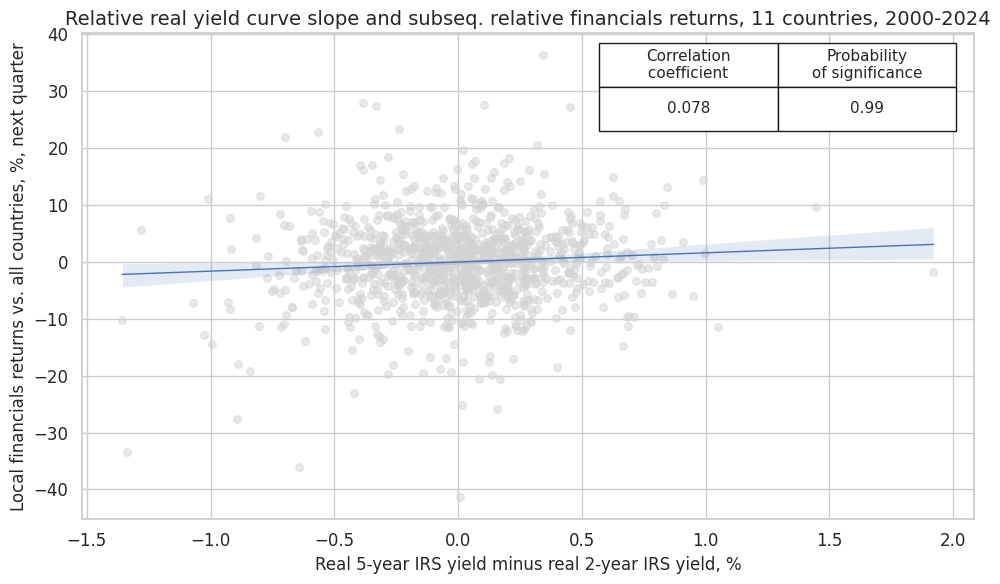

In [58]:
dix = dict_fixc

sig = dix["sigs"][0]
ret = dix["rets"][0]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx_mat = msp.CategoryRelations(
    dfx,
    xcats=[sig, ret],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=None,
)
crx_mat.reg_scatter(
    labels=False,
    coef_box="upper right",
    xlab="Real 5-year IRS yield minus real 2-year IRS yield, %",
    ylab="Local financials returns vs. all countries, %, next quarter",
    title="Relative real yield curve slope and subseq. relative financials returns, 11 countries, 2000-2024",
    size=(10, 6),
    prob_est="map",
)

##### Accuracy and correlation check

[`SignalReturnRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) function from the `macrosynergy` package analyses and compares the relationships between the chosen signals and the panel of subsequent returns. There is no regression analysis involved, rather the sign of the signal is used for predicting the sign of the target.

In [59]:
dix = dict_fixc

sigs = dix["sigs"]
rets = dix["rets"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    df=dfx,
    cids=cidx,
    sigs=sigs,
    rets=rets,
    freqs="M",
    start="1995-01-01",
)

mrt = srr.multiple_relations_table(rets=rets, xcats=sigs)


In [60]:
display(mrt.sort_index().astype("float").round(3)[xms])

accuracy  \
Return             Signal                    Frequency Aggregation             
EQCFINRUSD_NSAvGLB PCREDIT_SJA_P1M1ML12vNGDP M         last            0.517   
                   RYLDSLOPE_NSAvGLB         M         last            0.514   

                                                                    bal_accuracy  \
Return             Signal                    Frequency Aggregation                 
EQCFINRUSD_NSAvGLB PCREDIT_SJA_P1M1ML12vNGDP M         last                0.518   
                   RYLDSLOPE_NSAvGLB         M         last                0.514   

                                                                    pos_sigr  \
Return             Signal                    Frequency Aggregation             
EQCFINRUSD_NSAvGLB PCREDIT_SJA_P1M1ML12vNGDP M         last            0.610   
                   RYLDSLOPE_NSAvGLB         M         last            0.516   

                                                                    pos_retr  \
Return             Signal                    Frequency Aggregation             
EQCFINRUSD_NSAvGLB PCREDIT_SJA_P1M1ML12vNGDP M         last            0.500   
                   RYLDSLOPE_NSAvGLB         M         last            0.501   

                                                                    pearson  \
Return             Signal                    Frequency Aggregation            
EQCFINRUSD_NSAvGLB PCREDIT_SJA_P1M1ML12vNGDP M         last           0.033   
                   RYLDSLOPE_NSAvGLB         M         last           0.054   

                                                                    pearson_pval  \
Return             Signal                    Frequency Aggregation                 
EQCFINRUSD_NSAvGLB PCREDIT_SJA_P1M1ML12vNGDP M         last                0.055   
                   RYLDSLOPE_NSAvGLB         M         last                0.002   

                                                                    kendall  \
Return             Signal                    Frequency Aggregation            
EQCFINRUSD_NSAvGLB PCREDIT_SJA_P1M1ML12vNGDP M         last           0.021   
                   RYLDSLOPE_NSAvGLB         M         last           0.024   

                                                                    kendall_pval  
Return             Signal                    Frequency Aggregation                
EQCFINRUSD_NSAvGLB PCREDIT_SJA_P1M1ML12vNGDP M         last                0.067  
                   RYLDSLOPE_NSAvGLB         M         last                0.037